In [8]:
#1
# Commented out IPython magic to ensure Python compatibility.
%pip install pm4py
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pm4py

In [9]:
#2
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/BPI_Challenge_2019.xes'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#3
## Importing the event log dataset in a pandas dataframe
log_df = pm4py.read_xes(file_path)

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/251734 [00:00<?, ?it/s]

In [11]:
#4
log_df.rename(columns={'Case ID': 'case:concept:name', 'Complete Timestamp': 'time:timestamp', 'Activity': 'concept:name', 'Resource': 'org:resource'}, inplace=True) #changing the names of the colum

# converting the 'Date' column to datetime format
log_df['time:timestamp']= pd.to_datetime(log_df['time:timestamp'])

num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
#printing the number of events and number of cases to the screen
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


#printing the start activities and the end activities to the screen
start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

#log_df

Number of events: 1595923
Number of cases: 251734
Start activities: {'Create Purchase Order Item': 199867, 'Create Purchase Requisition Item': 46526, 'Vendor creates invoice': 3457, 'SRM: Created': 1360, 'Change Approval for Purchase Order': 378, 'Vendor creates debit memo': 122, 'Release Purchase Order': 22, 'Change Currency': 2}
End activities: {'Clear Invoice': 181328, 'Record Invoice Receipt': 23091, 'Record Goods Receipt': 22776, 'Delete Purchase Order Item': 8123, 'Remove Payment Block': 5397, 'Create Purchase Order Item': 4447, 'Cancel Invoice Receipt': 1348, 'Change Approval for Purchase Order': 1346, 'Record Service Entry Sheet': 921, 'Change Delivery Indicator': 718, 'Change Price': 529, 'Change Quantity': 525, 'Cancel Goods Receipt': 440, 'Receive Order Confirmation': 232, 'Block Purchase Order Item': 167, 'Vendor creates invoice': 68, 'Set Payment Block': 61, 'SRM: Change was Transmitted': 47, 'SRM: Transfer Failed (E.Sys.)': 44, 'SRM: In Transfer to Execution Syst.': 30, '

In [12]:
#5
"""**FILTERING NOISE**
1.   Activity with null time duration(zero time duration)
2.   Incomplete cases
3.   Summarizing the log
"""

# Activity with null time duration

## Geting the max duration
case_durations = pm4py.get_all_case_durations(log_df)
#print(case_durations)

## Alternative way using dataframe
case_durations = log_df.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ...
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min()),
)
#print(case_durations)

## Verify the cases that we have with duration 0
min_case_duration = case_durations['Duration'].min()
max_case_duration = case_durations['Duration'].max()
mean_case_duration = case_durations['Duration'].mean()

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))

filtered_log = pm4py.filter_case_performance(log_df, 0, 0)

#print(len(log_df))
#print(len(filtered_log['case:concept:name'].unique()))

print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(log_df['case:concept:name'].unique()), len(filtered_log['case:concept:name'].unique())))

## Verify they are all noise

variants = pm4py.get_variants(filtered_log)

print(variants)
## Let's filter on cases with duration 0 and not ending with a Payment activity
"""
filtered_log = pm4py.filter_variants(log_df, [('Create Purchase Order Item', 'Delete Purchase Order Item')], retain=True)
filtered_log = pm4py.filter_case_performance(filtered_log, 0, 0)
variants = pm4py.get_variants(filtered_log)
print(variants)
"""

## Let's remove this log segment from the total event log
### we use pandas functions to get the difference between data frames
### pm4py unfortunately offers very limited options for set operations with event logs

#log_df_diff = log_df.compare(filtered_log) # working only if the dataframe have the same index

log_df = pd.concat([log_df,filtered_log]).drop_duplicates(keep=False)

num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())

print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

## Get max duration
case_durations = pm4py.get_all_case_durations(log_df)
#print(case_durations)

## Alternative way using dataframe
case_durations = log_df.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ...
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min()),
)
#print(case_durations)

## Let's verify we have cases with duration 0
min_case_duration = case_durations['Duration'].min()
max_case_duration = case_durations['Duration'].max()
mean_case_duration = case_durations['Duration'].mean()

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))

Min Case Duration: 0 days 00:00:00
Max Case Duration: 25670 days 13:09:00
Mean Case Duration: 71 days 12:35:19.549921741
Given 251734 total cases in the log we have 3585 cases that comply with the applied filter
{('Create Purchase Order Item', 'Delete Purchase Order Item'): 55, ('Create Purchase Order Item', 'Record Goods Receipt', 'Record Goods Receipt', 'Record Goods Receipt', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Service Entry Sheet'): 5, ('Create Purchase Order Item',): 2835, ('Create Purchase Order Item', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Goods Receipt'): 20, ('Create Purchase Order Item', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Record Goods Receipt'): 67, ('Create Purchase Order Item', 'Record Service Entry Sheet', 'Record Service Entry Sheet', 'Rec

Number of events: 985323
Number of cases(3-way matching): 196419
Number of events (2-way): 1116246
Number of cases (2-way): 219497


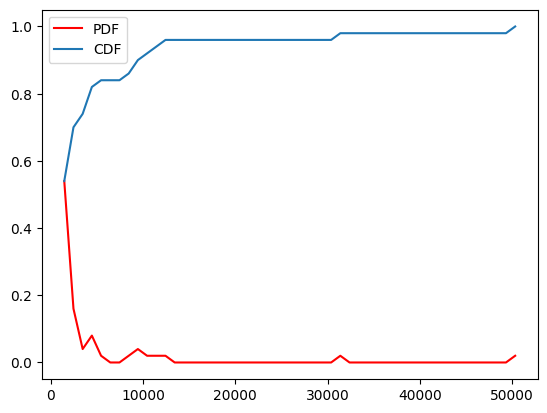

In [13]:
#6
# SUMMARISING
filtered_log = log_df
variants = pm4py.get_variants(filtered_log)
#print(variants)
variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count'])
# create a new column with index values
#variants_df['Variant'] = variants_df.index
variants_df = variants_df.reset_index()
variants_df = variants_df.rename(columns={'index': 'Variant'})
variants_df = variants_df.sort_values(by=['Count'], ascending=False)
variants_df = variants_df.reset_index(drop=True)
variants_df

# Commented out IPython magic to ensure Python compatibility.
## Let's plot the PDF


data= variants_df['Count'].head(50)

# getting data of the histogram
count, bins_count = np.histogram(data, bins=50)

# finding the PDF of the histogram using count values
pdf = count / sum(count)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)

# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

## Let's extract the top k (40) variants
#retain the top k (40) variants
keeps=filtered_log
filtered_log = pm4py.filter_variants_top_k(filtered_log, 40)
filtered_log_for_3 = pm4py.filter_variants_top_k(keeps, 150)

#calculate the number of the events and cases for 3-way matching
num_events_3way = len(filtered_log)
num_cases_3way = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases(3-way matching): {}".format(num_events_3way, num_cases_3way))

num_events_2way = len(filtered_log_for_3) #this is for 2-way matching, since it has too little amount of cases when compared to others
num_cases_2way = len(filtered_log_for_3['case:concept:name'].unique())
print("Number of events (2-way): {}\nNumber of cases (2-way): {}".format(num_events_2way, num_cases_2way))

In [14]:
#7

#Filtering / grouping dataframe according to their item category types.

#k3=filtered_log


newData1 = filtered_log[filtered_log["case:Item Category"]=="3-way match, invoice after GR"]
newData2 = filtered_log[filtered_log["case:Item Category"]=="3-way match, invoice before GR"]
newData3 = filtered_log_for_3[filtered_log_for_3["case:Item Category"]=="2-way match"]
newData4 = filtered_log[filtered_log["case:Item Category"]=="Consignment"]
#for i in log["case:Item Category"]:
 # print(i)
    #if i["case:Item Category"] == {"3-way match, invoice before GR"}:
     #   newDataFrame.append(i)

#df = pd.DataFrame(newDataFrame)
"""
for i in newData2:
  print(newData2['case:Item Category'])
"""

"\nfor i in newData2:\n  print(newData2['case:Item Category'])\n"

In [15]:
#8
# Incomplete cases 3 way matching, invoice after GR

## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection
newData1_3way_after = newData1
newData1 = pm4py.filter_end_activities(newData1_3way_after, ['Delete Purchase Order Item'])

print("Given {} total cases in the log we have {} cases that is eleminated with the applied filter".format(len(newData1_3way_after['case:concept:name'].unique()), len(newData1['case:concept:name'].unique())))
#print("The cycle time of the entire log is {} while the cycle time of the cases that comply with the applied filter is {}".format(cycle_time_log, cycle_time_filtered_log))

## Let's merge the log segments we obtained

newData1 = pd.concat([newData1_3way_after,newData1]).drop_duplicates(keep=False)
num_events = len(newData1)
num_cases = len(newData1['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
use_later_data1 = newData1

Given 7350 total cases in the log we have 273 cases that is eleminated with the applied filter
Number of events: 34663
Number of cases: 7077


In [16]:
#9
# 3 way matching, invoice before GR

## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection
newData2_3way_before = newData2
newData2 = pm4py.filter_end_activities(newData2_3way_before, ['Delete Purchase Order Item'])

print("Given {} total cases in the log we have {} cases that is eleminated with the applied filter".format(len(newData2_3way_before['case:concept:name'].unique()), len(newData2['case:concept:name'].unique())))
#print("The cycle time of the entire log is {} while the cycle time of the cases that comply with the applied filter is {}".format(cycle_time_log, cycle_time_filtered_log))

## Let's merge the log segments we obtained

newData2 = pd.concat([newData2_3way_before,newData2]).drop_duplicates(keep=False)
num_events = len(newData2)
num_cases = len(newData2['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

use_later_data2 = newData2

Given 177093 total cases in the log we have 6333 cases that is eleminated with the applied filter
Number of events: 909197
Number of cases: 170760


In [17]:
#10
#2-way matching
newData3_2way = newData3
# Filter cases containing 'Delete Purchase Order Item'
filtered_cases = newData3_2way[~newData3_2way['case:concept:name'].isin(
    newData3_2way.loc[newData3_2way['concept:name'] == 'Delete Purchase Order Item', 'case:concept:name'].unique()
)]
pp = len(newData3_2way['case:concept:name'].unique()) - len(filtered_cases['case:concept:name'].unique())
print("Given {} total cases in the log we have {} cases that is eleminated with the applied filter".format(len(newData3_2way['case:concept:name'].unique()), pp))
#print("The cycle time of the entire log is {} while the cycle time of the cases that comply with the applied filter is {}".format(cycle_time_log, cycle_time_filtered_log))

# Filter events based on remaining cases
newData3 = newData3_2way[newData3_2way['case:concept:name'].isin(filtered_cases['case:concept:name'].unique())]

num_events = len(newData3)
num_cases = len(newData3['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
use_later_data3 = newData3

Given 539 total cases in the log we have 3 cases that is eleminated with the applied filter
Number of events: 1692
Number of cases: 536


In [18]:
#11
#Consignment

## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection
newData4_2 = newData4
newData4 = pm4py.filter_end_activities(newData4_2, ['Delete Purchase Order Item'])

print("Given {} total cases in the log we have {} cases that eleminated with the applied filter".format(len(newData4_2['case:concept:name'].unique()), len(newData4['case:concept:name'].unique())))
#print("The cycle time of the entire log is {} while the cycle time of the cases that comply with the applied filter is {}".format(cycle_time_log, cycle_time_filtered_log))

## Let's merge the log segments we obtained

newData4 = pd.concat([newData4_2,newData4]).drop_duplicates(keep=False)
num_events = len(newData4)
num_cases = len(newData4['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
use_later_data4 = newData4

Given 11976 total cases in the log we have 328 cases that eleminated with the applied filter
Number of events: 25910
Number of cases: 11648


     case:concept:name            time:timestamp                          
                                             max                       min
0     4507000227_00010 2018-03-29 13:06:00+00:00 2018-01-02 06:23:00+00:00
1     4507000239_00030 2018-01-25 15:54:00+00:00 2018-01-02 06:48:00+00:00
2     4507000239_00080 2018-01-25 15:54:00+00:00 2018-01-02 06:48:00+00:00
3     4507000282_00030 2018-03-29 13:07:00+00:00 2018-01-02 10:06:00+00:00
4     4507000322_00050 2018-04-26 09:14:00+00:00 2018-01-02 10:47:00+00:00
...                ...                       ...                       ...
7072  4508075856_00010 2018-12-21 13:59:00+00:00 2018-12-20 23:00:00+00:00
7073  4508075861_00010 2018-12-21 14:35:00+00:00 2018-12-20 23:00:00+00:00
7074  4508075911_00001 2019-01-11 10:11:00+00:00 2018-12-26 21:57:00+00:00
7075  4508075952_00020 2019-01-03 16:46:00+00:00 2018-12-29 23:00:00+00:00
7076  4508075952_00120 2019-01-09 16:36:00+00:00 2018-12-30 23:00:00+00:00

[7077 rows x 3 columns]


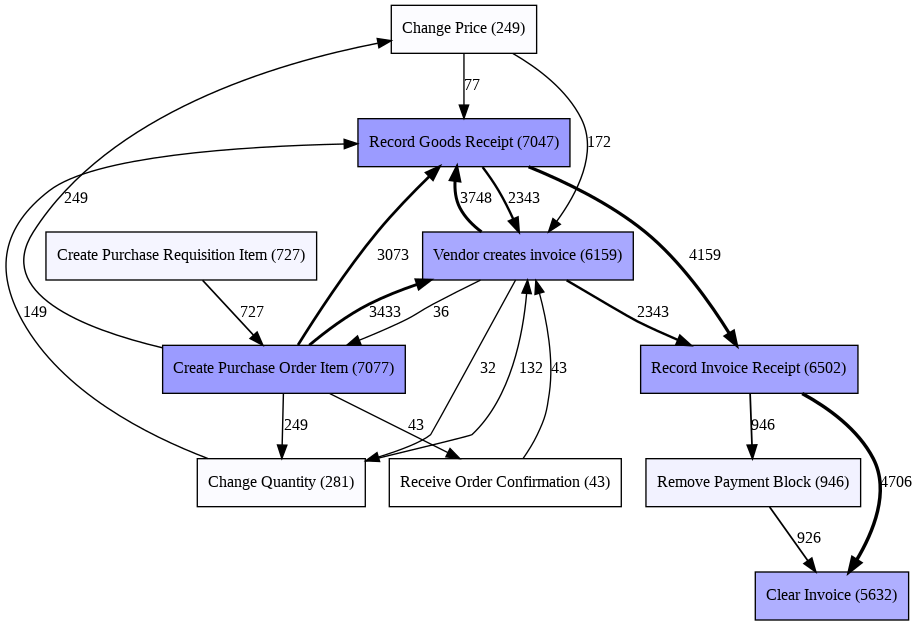

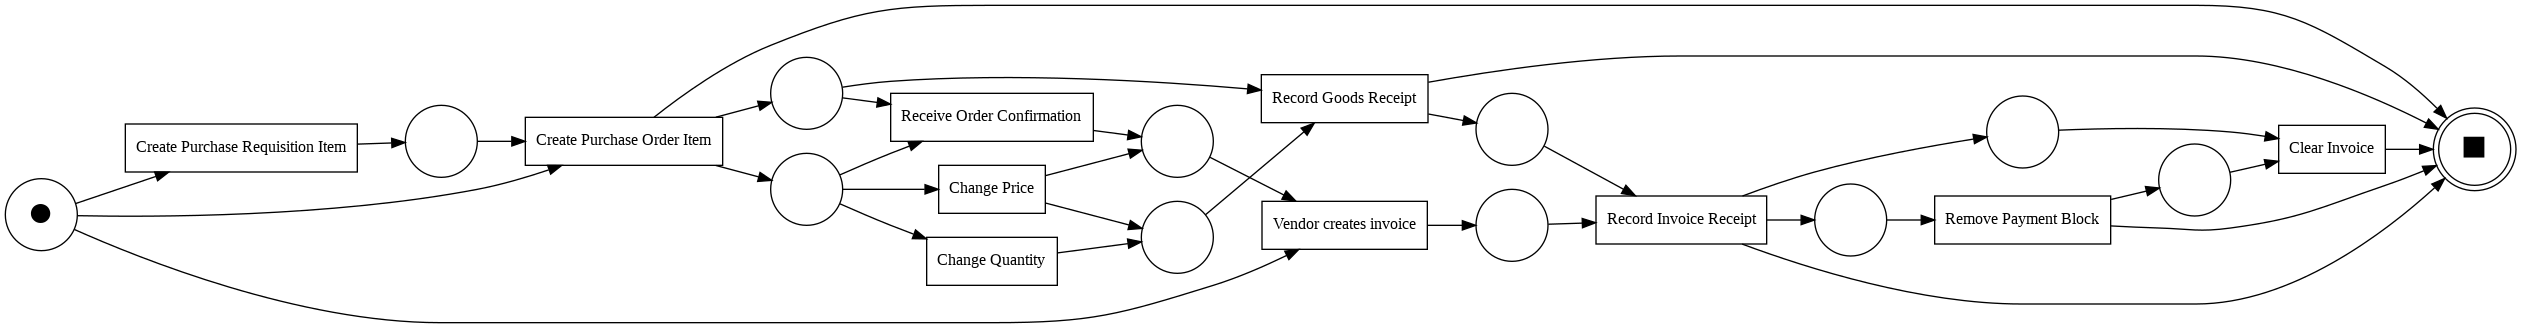

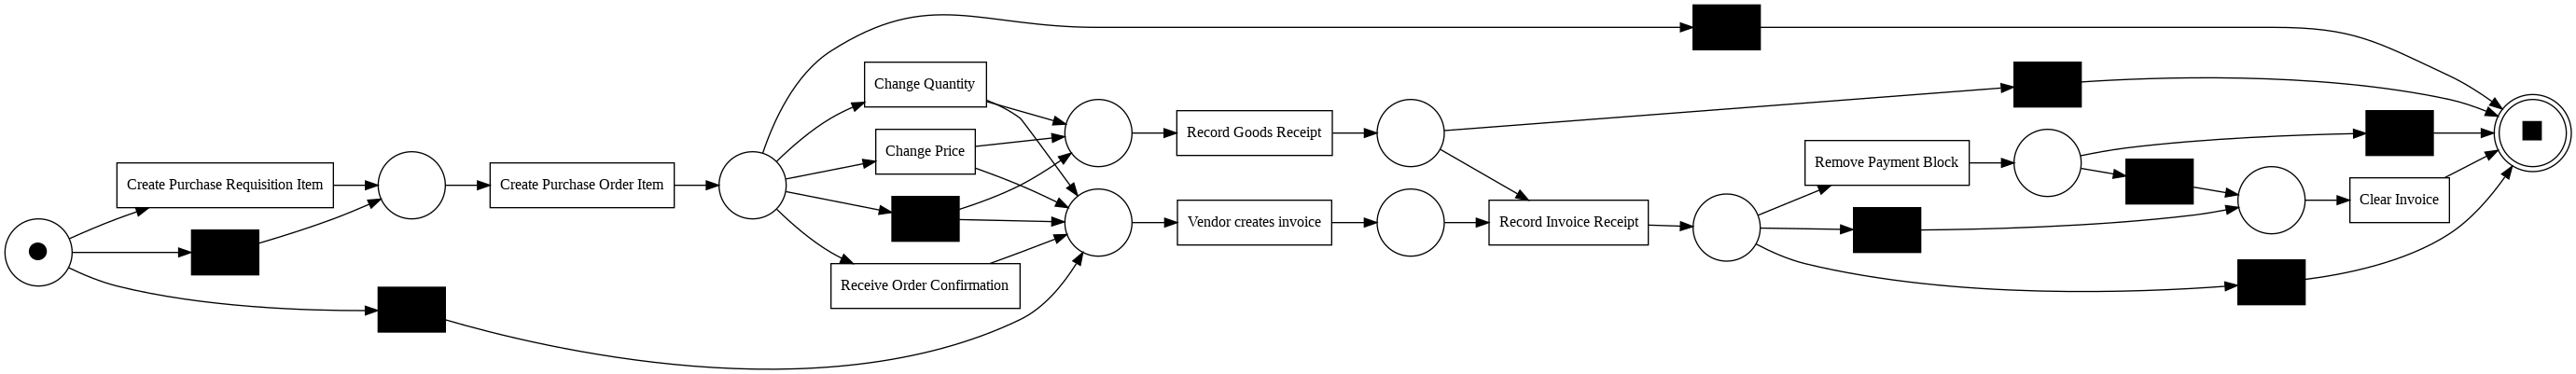

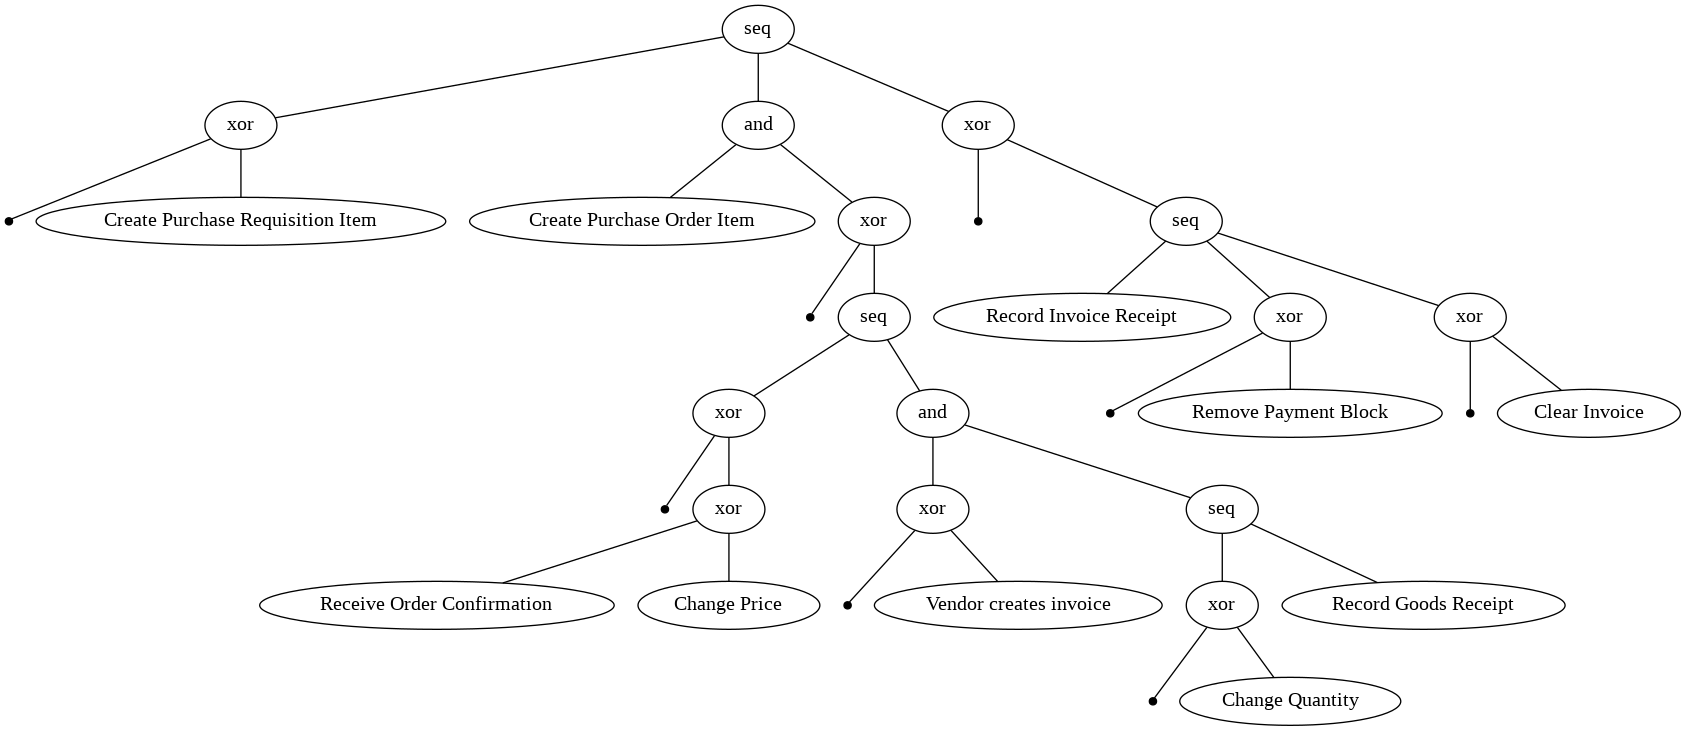

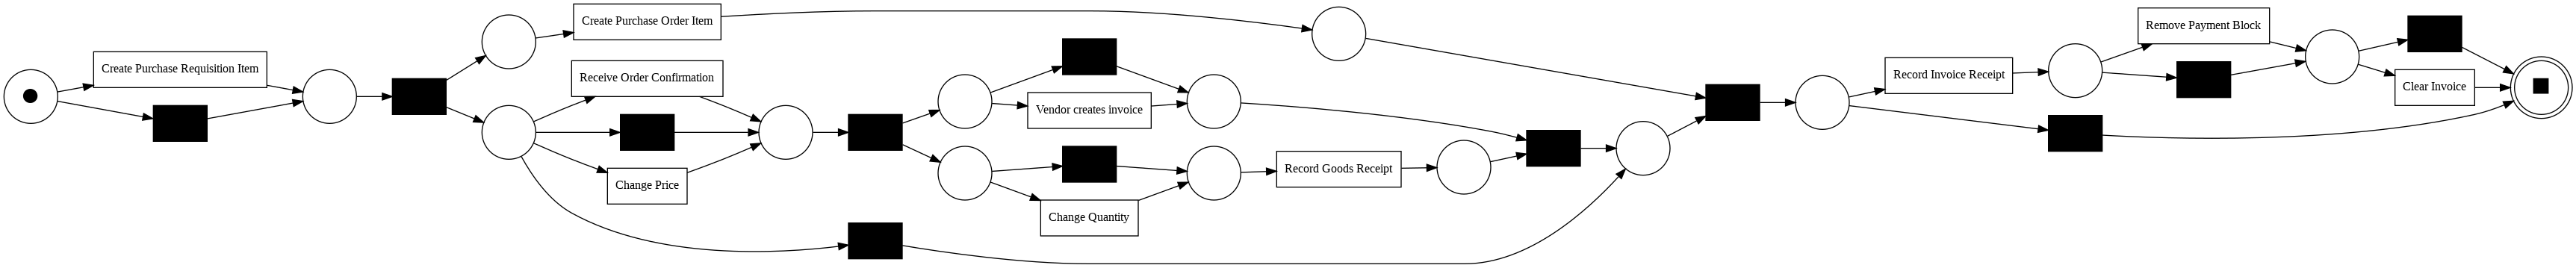

discovering Petri net using ILP miner, completed causal relations ::   0%|          | 0/22 [00:00<?, ?it/s]

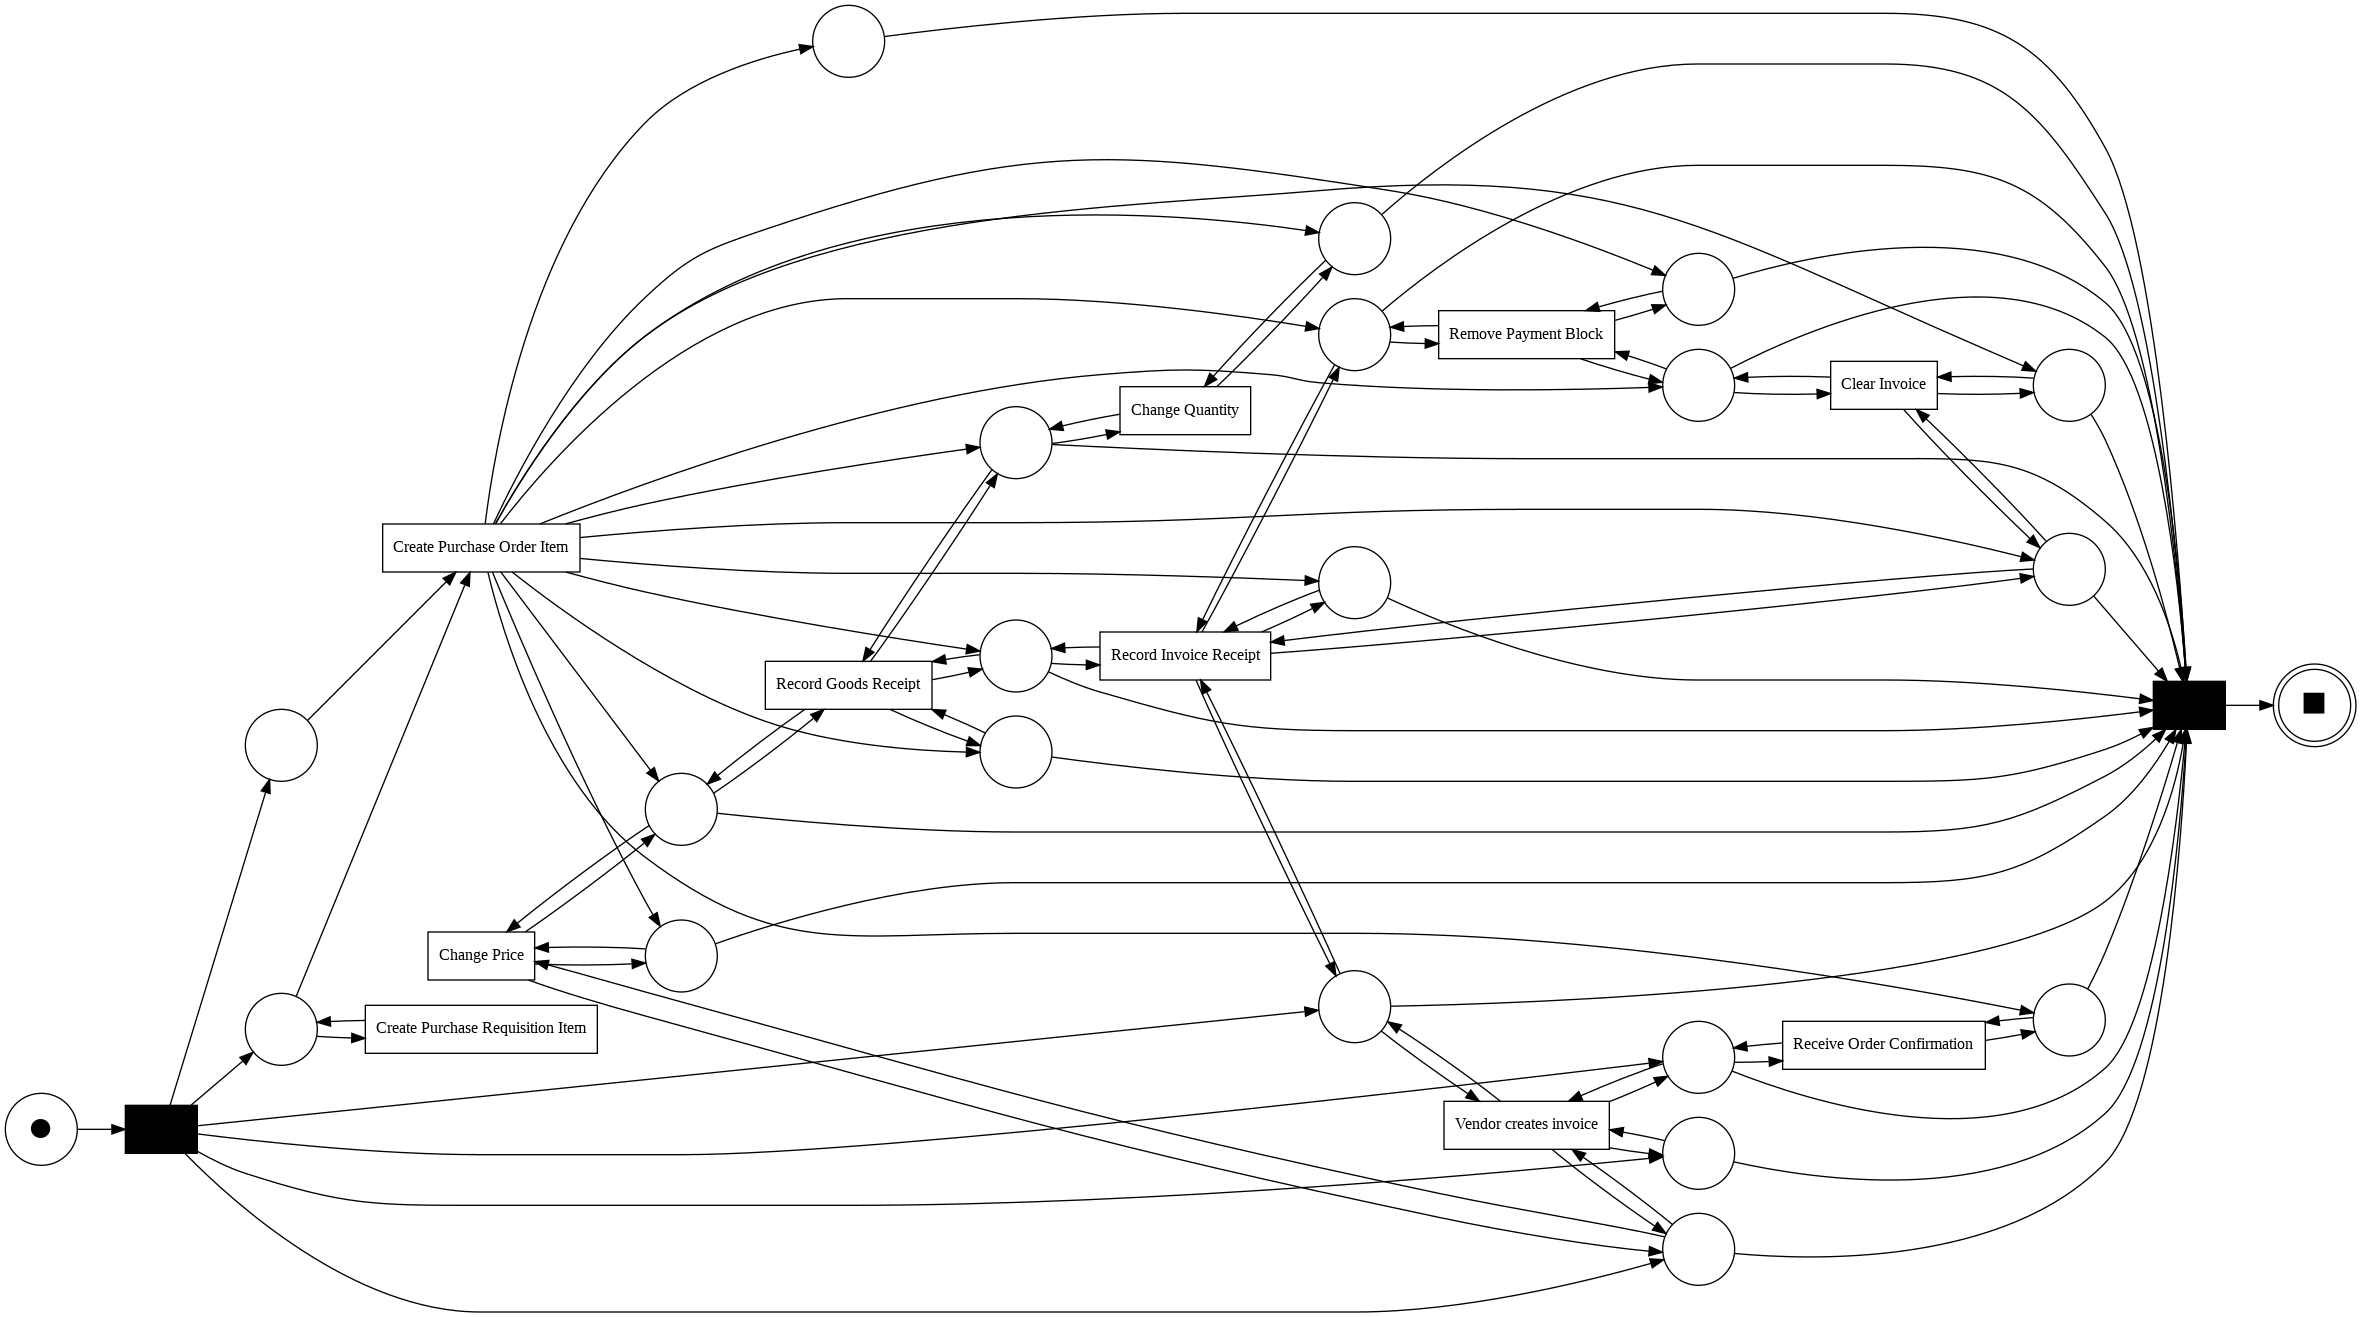

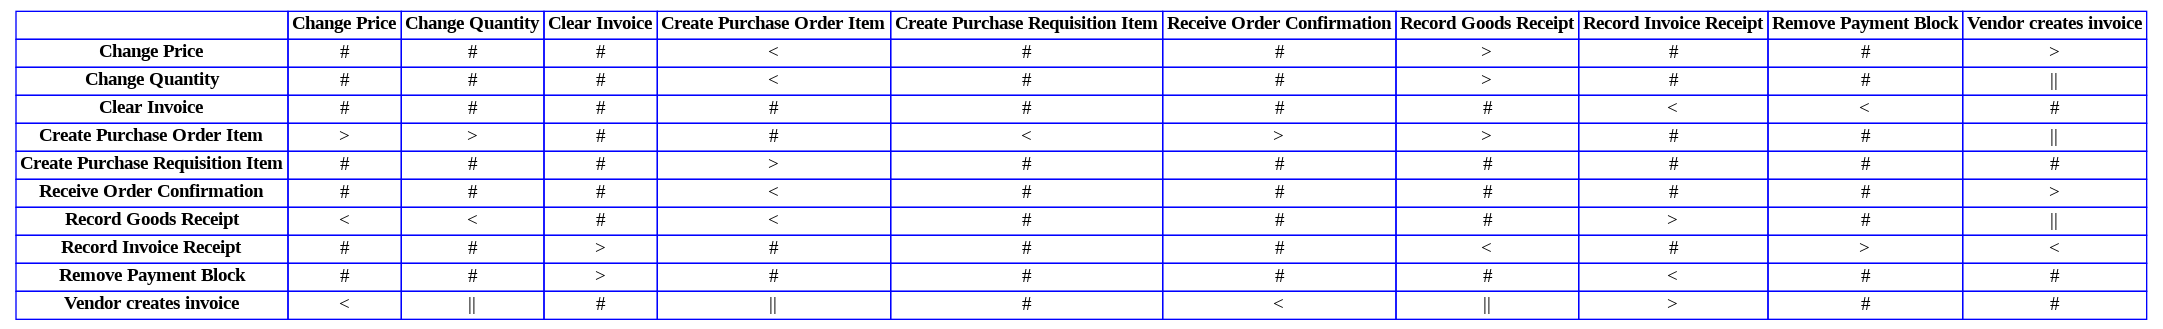

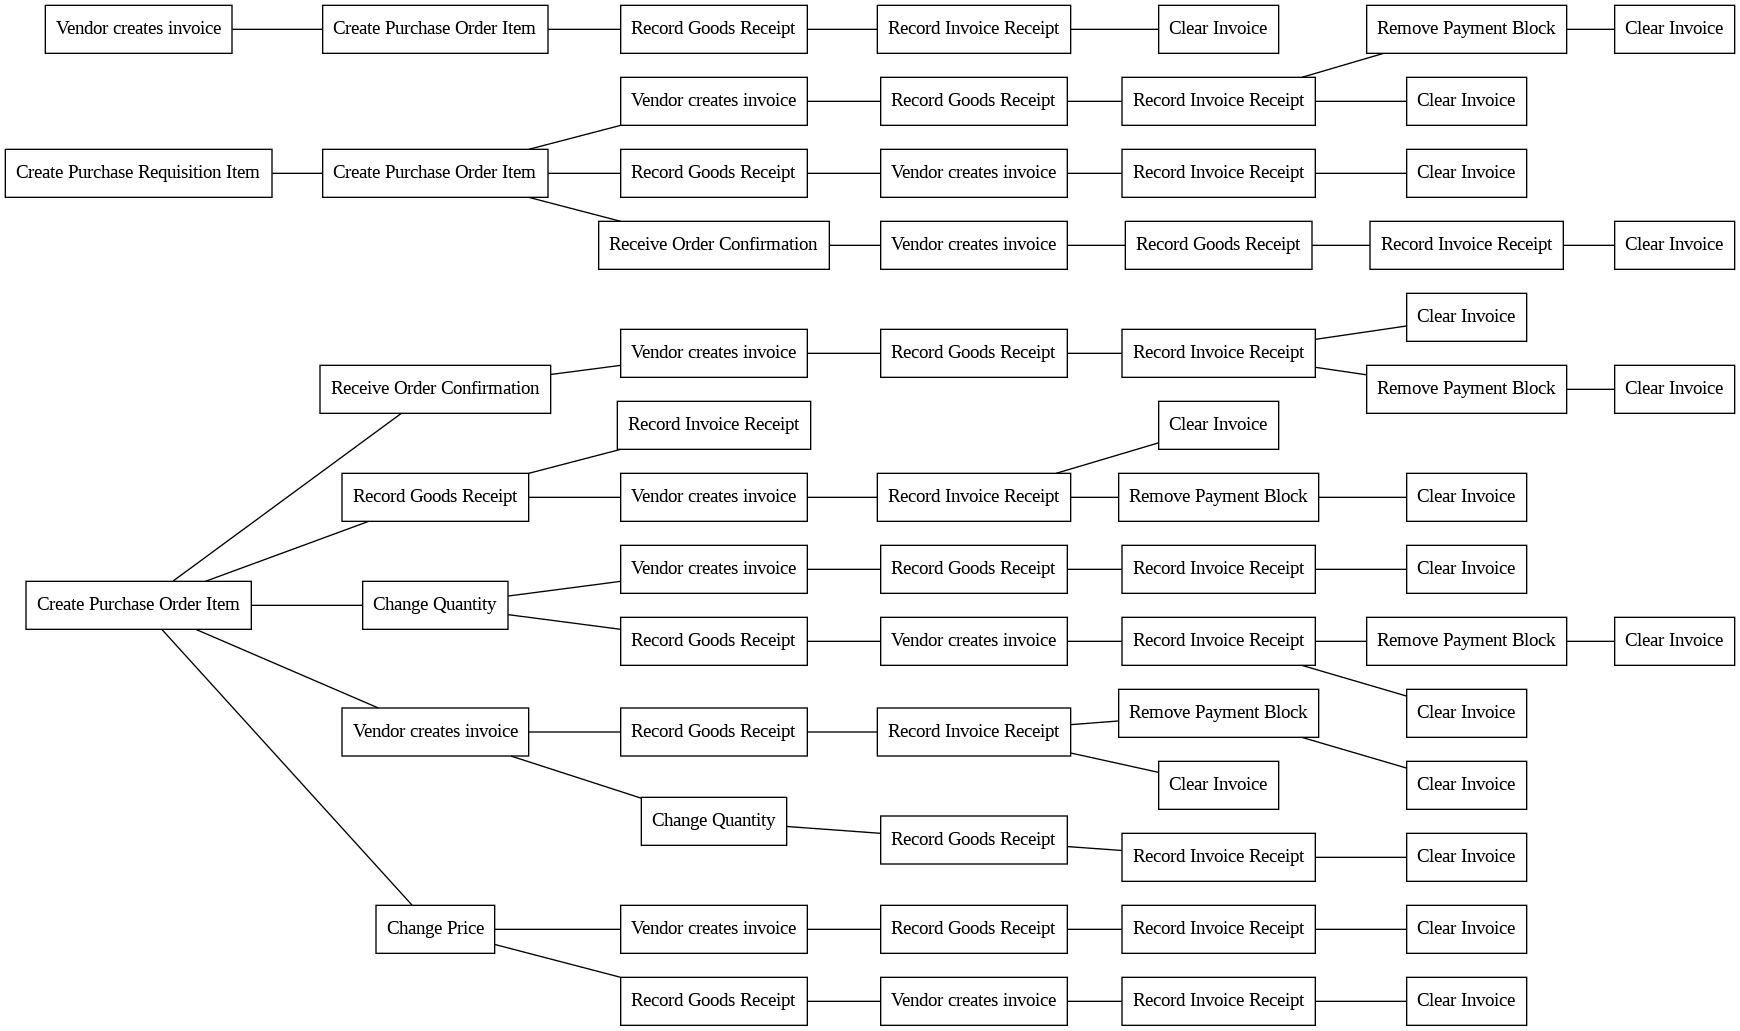

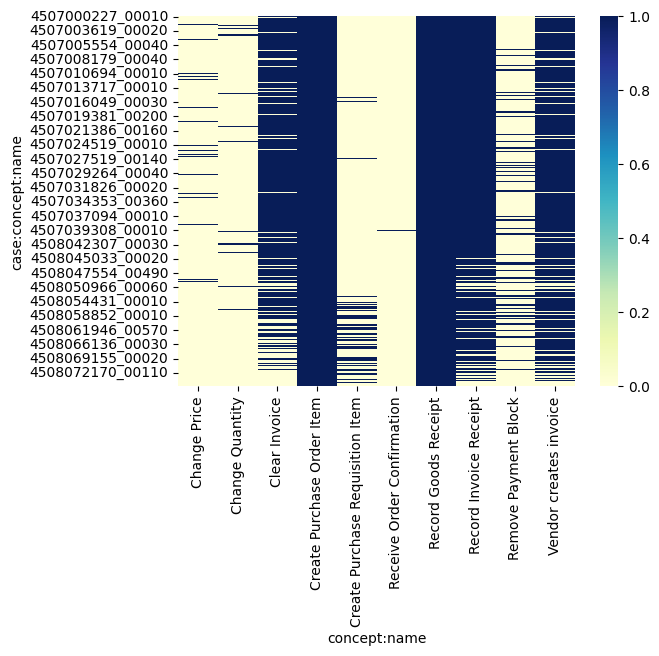

In [21]:
#12
#Process dicovery for 3-way match, invoice after GR

# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
# %pip install pm4py
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = newData1.pivot_table(index='case:concept:name', aggfunc={'time:timestamp': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
print(case_starts_ends)

case_starts_ends.columns = ['case:concept:name', 'caseend', 'casestart']

# Merge with the main event log data so that for each row we have the start and end times.
newData1 = newData1.merge(case_starts_ends, on='case:concept:name')

# Calculate the relative time by subtracting the process start time from the event timestamp
newData1['cumulativetime'] = newData1['time:timestamp'] - newData1['casestart']
# Convert relative times to more friendly measures
## seconds

newData1['cumulativetime_s'] = newData1['cumulativetime'].dt.seconds + 86400*newData1['cumulativetime'].dt.days
## days
newData1['cumulativedays'] = newData1['cumulativetime'].dt.days

print(newData1)

## Get an array of patient labels for the y axis - for graph labelling purposes
casenums = [int(e) for e in newData1['case:concept:name'].apply(lambda x: x.strip('case:concept:name'))]
## Plot a scatter plot of patient events over relative time
"""
ax = sns.scatterplot(x=newData1['cumulativetime_s'],
y=newData1['case:concept:name'], hue=newData1['concept:name'])
"""

## Create a table giving the number of cases in which each event is present.
my_events = pd.crosstab(newData1['case:concept:name'], newData1['concept:name'])
## Visualise in a heatmap
sns.heatmap(my_events, cmap="YlGnBu")
# Comply to the naming standard of PM4PY

#newData1.rename(columns={'datetime': 'time:timestamp',
#'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)


## Convert to log format
#log = log_converter.apply(log_csv)

## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization

#Create graph from log
dfg = dfg_discovery.apply(newData1)
# Visualise
gviz = dfg_visualization.apply(dfg, log=newData1, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Alpha_miner algorithm
net, im, fm = pm4py.discover_petri_net_alpha(newData1)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')

# Discover petri net using heuristics miner

net, im, fm = pm4py.discover_petri_net_heuristics(newData1, and_threshold = 0.9)

pm4py.view_petri_net(net, im, fm, format='png')

# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(newData1)

pm4py.view_process_tree(process_tree, format='png')

# Discover petri net using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(newData1)

pm4py.view_petri_net(net, im, fm, format='png')

# Discover petri net using  Integer Linear Programming

net, im, fm = pm4py.discover_petri_net_ilp(newData1)

pm4py.view_petri_net(net, im, fm, format='png')

footprints = pm4py.discover_footprints(newData1)
pm4py.view_footprints(footprints, format='png')

prefix_tree = pm4py.discover_prefix_tree(newData1)
pm4py.view_prefix_tree(prefix_tree, format='png')


       case:concept:name            time:timestamp                          
                                               max                       min
0       4507000223_00010 2018-03-29 13:08:00+00:00 2018-01-02 02:43:00+00:00
1       4507000224_00010 2018-02-22 15:17:00+00:00 2018-01-02 02:43:00+00:00
2       4507000225_00010 2018-02-22 15:17:00+00:00 2018-01-02 03:20:00+00:00
3       4507000225_00020 2018-02-22 15:17:00+00:00 2018-01-02 03:20:00+00:00
4       4507000225_00030 2018-02-22 15:17:00+00:00 2018-01-02 03:20:00+00:00
...                  ...                       ...                       ...
170755  4508075961_00020 2019-01-17 12:48:00+00:00 2018-12-30 23:00:00+00:00
170756  4508075961_00030 2019-01-17 12:48:00+00:00 2018-12-30 23:00:00+00:00
170757  4508075961_00040 2019-01-17 12:48:00+00:00 2018-12-31 08:01:00+00:00
170758  4508075961_00050 2019-01-17 12:48:00+00:00 2018-12-31 08:01:00+00:00
170759  4508075961_00060 2019-01-17 12:48:00+00:00 2018-12-31 08:01:00+00:00

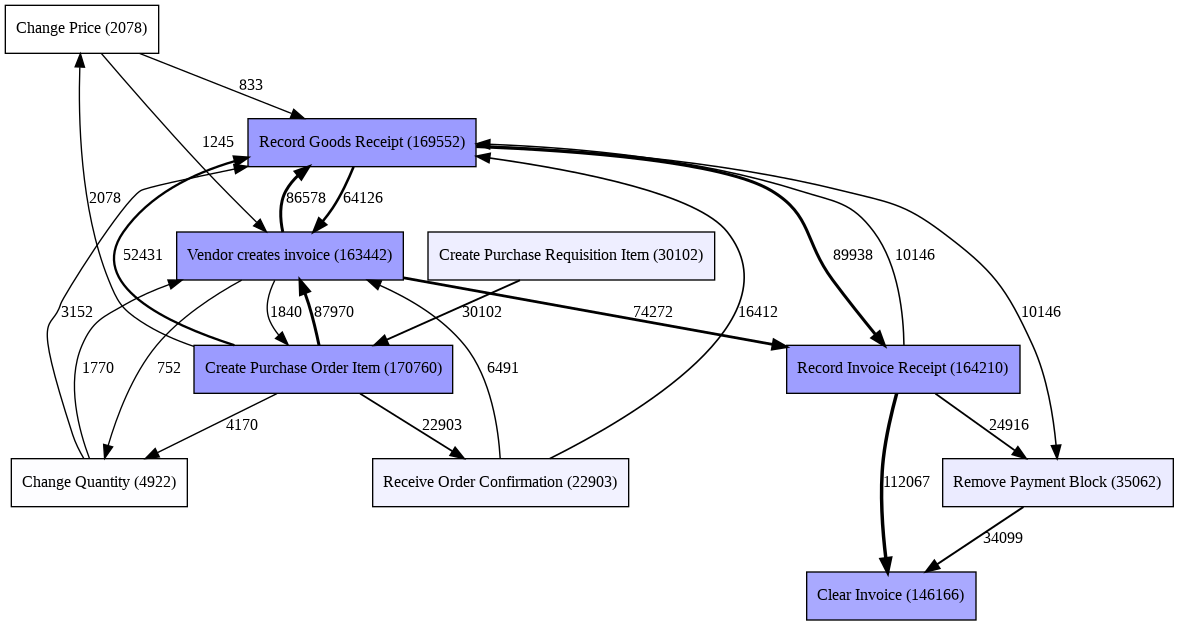

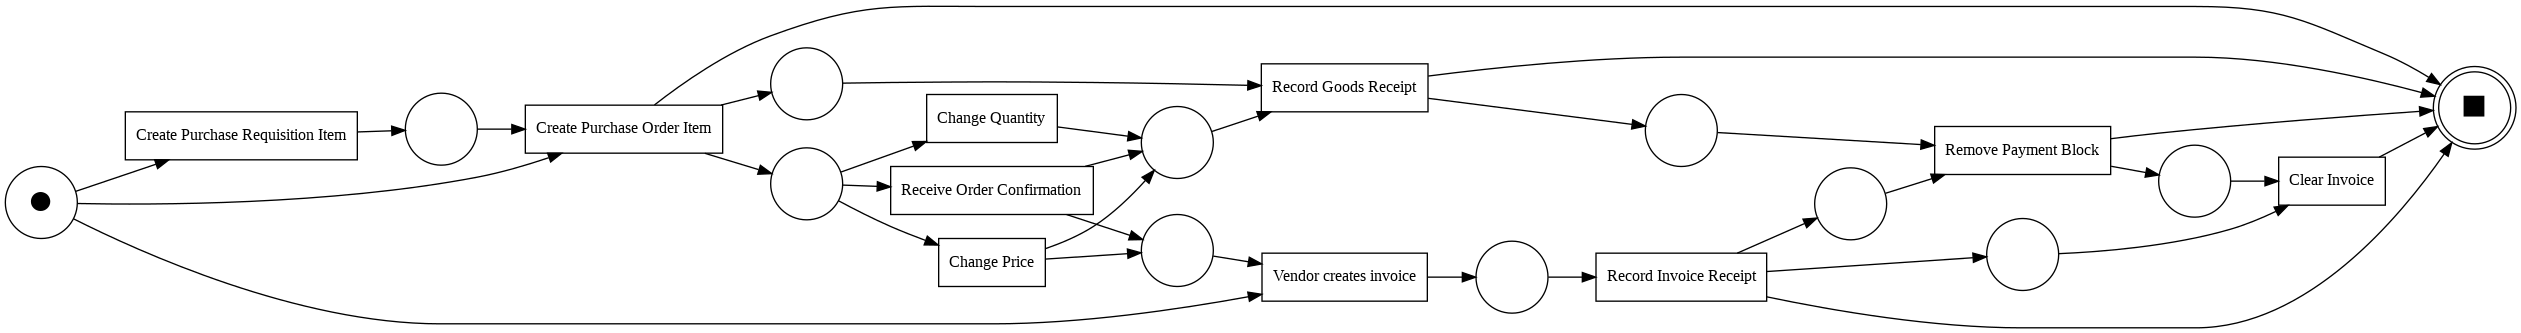

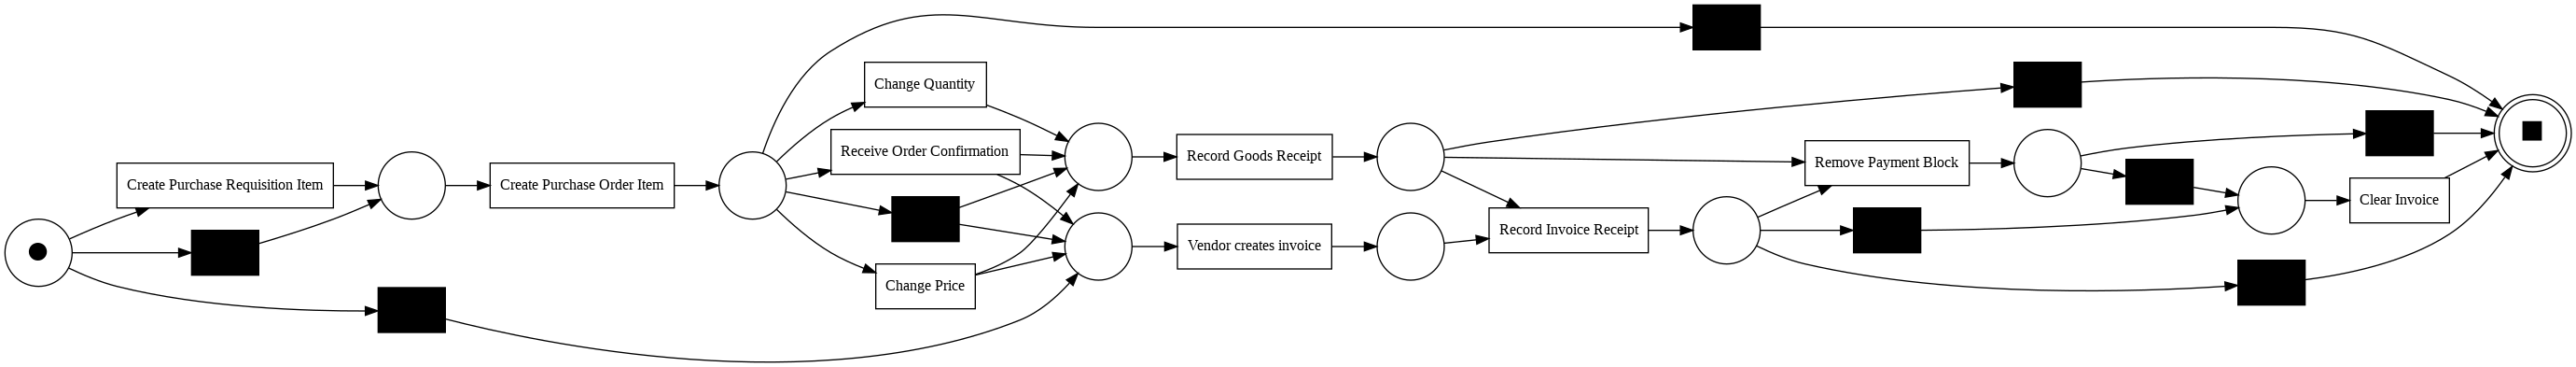

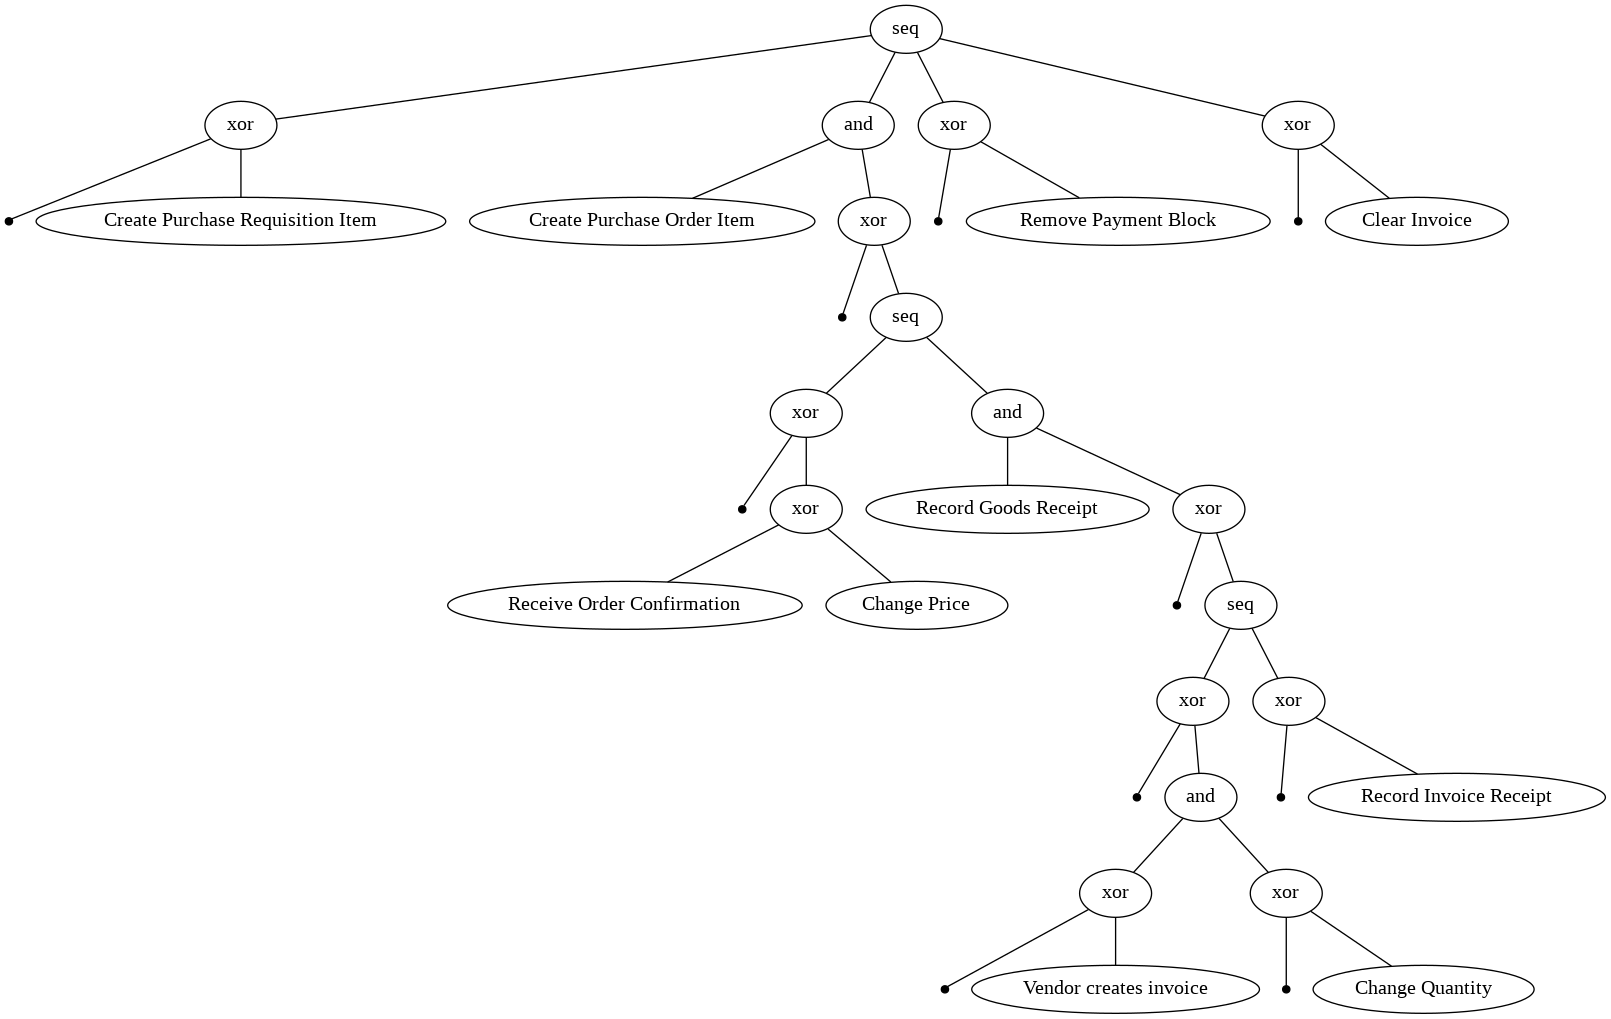

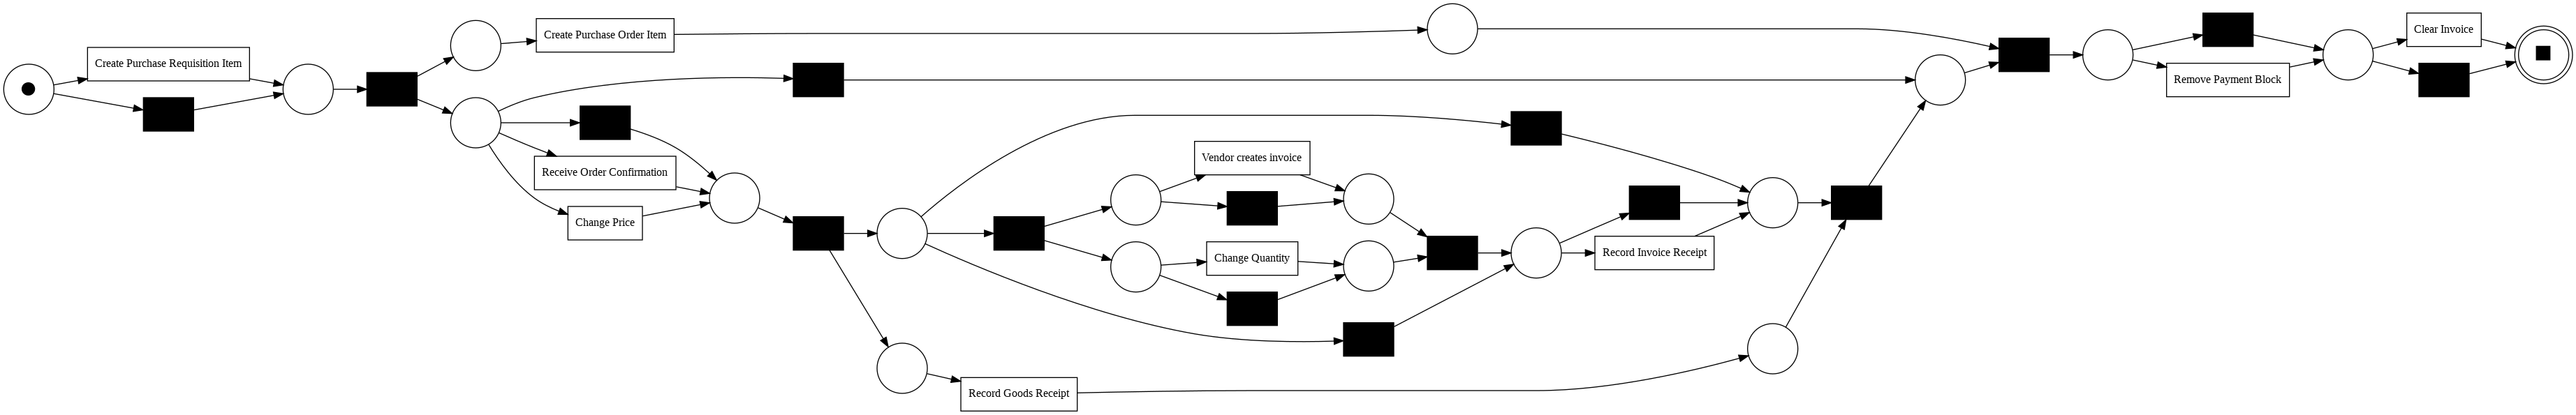

discovering Petri net using ILP miner, completed causal relations ::   0%|          | 0/23 [00:00<?, ?it/s]

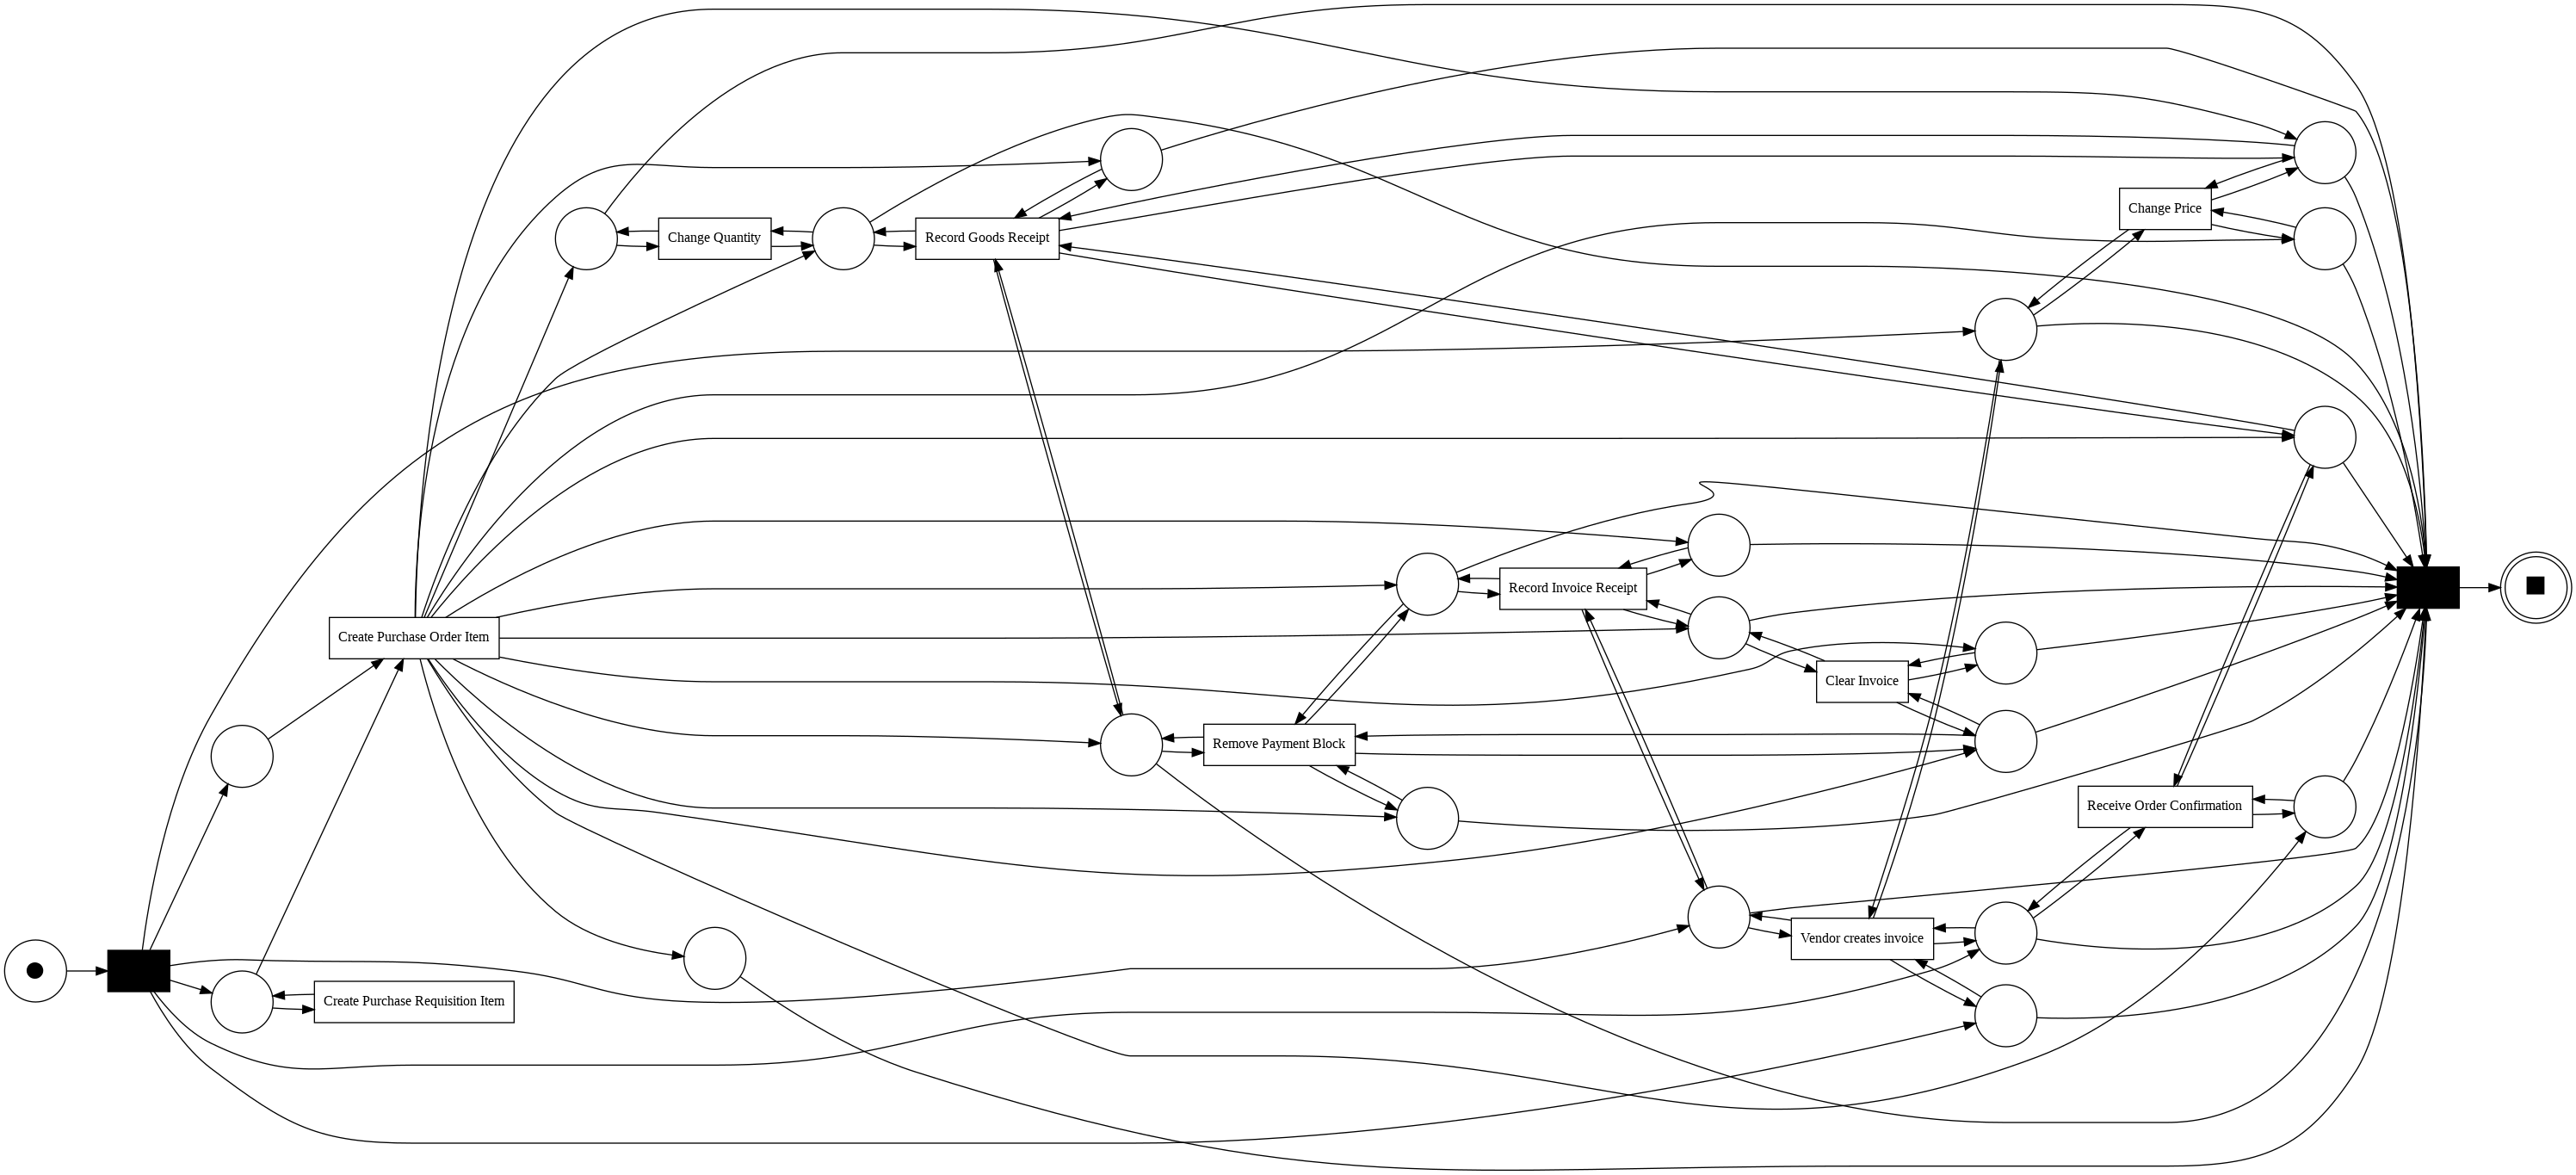

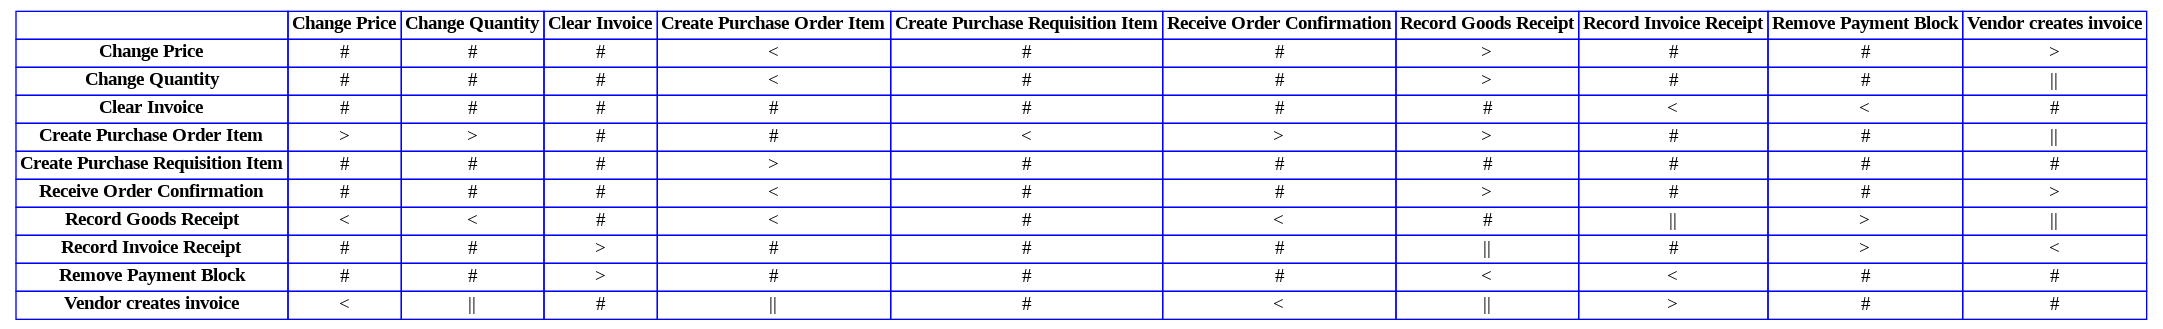

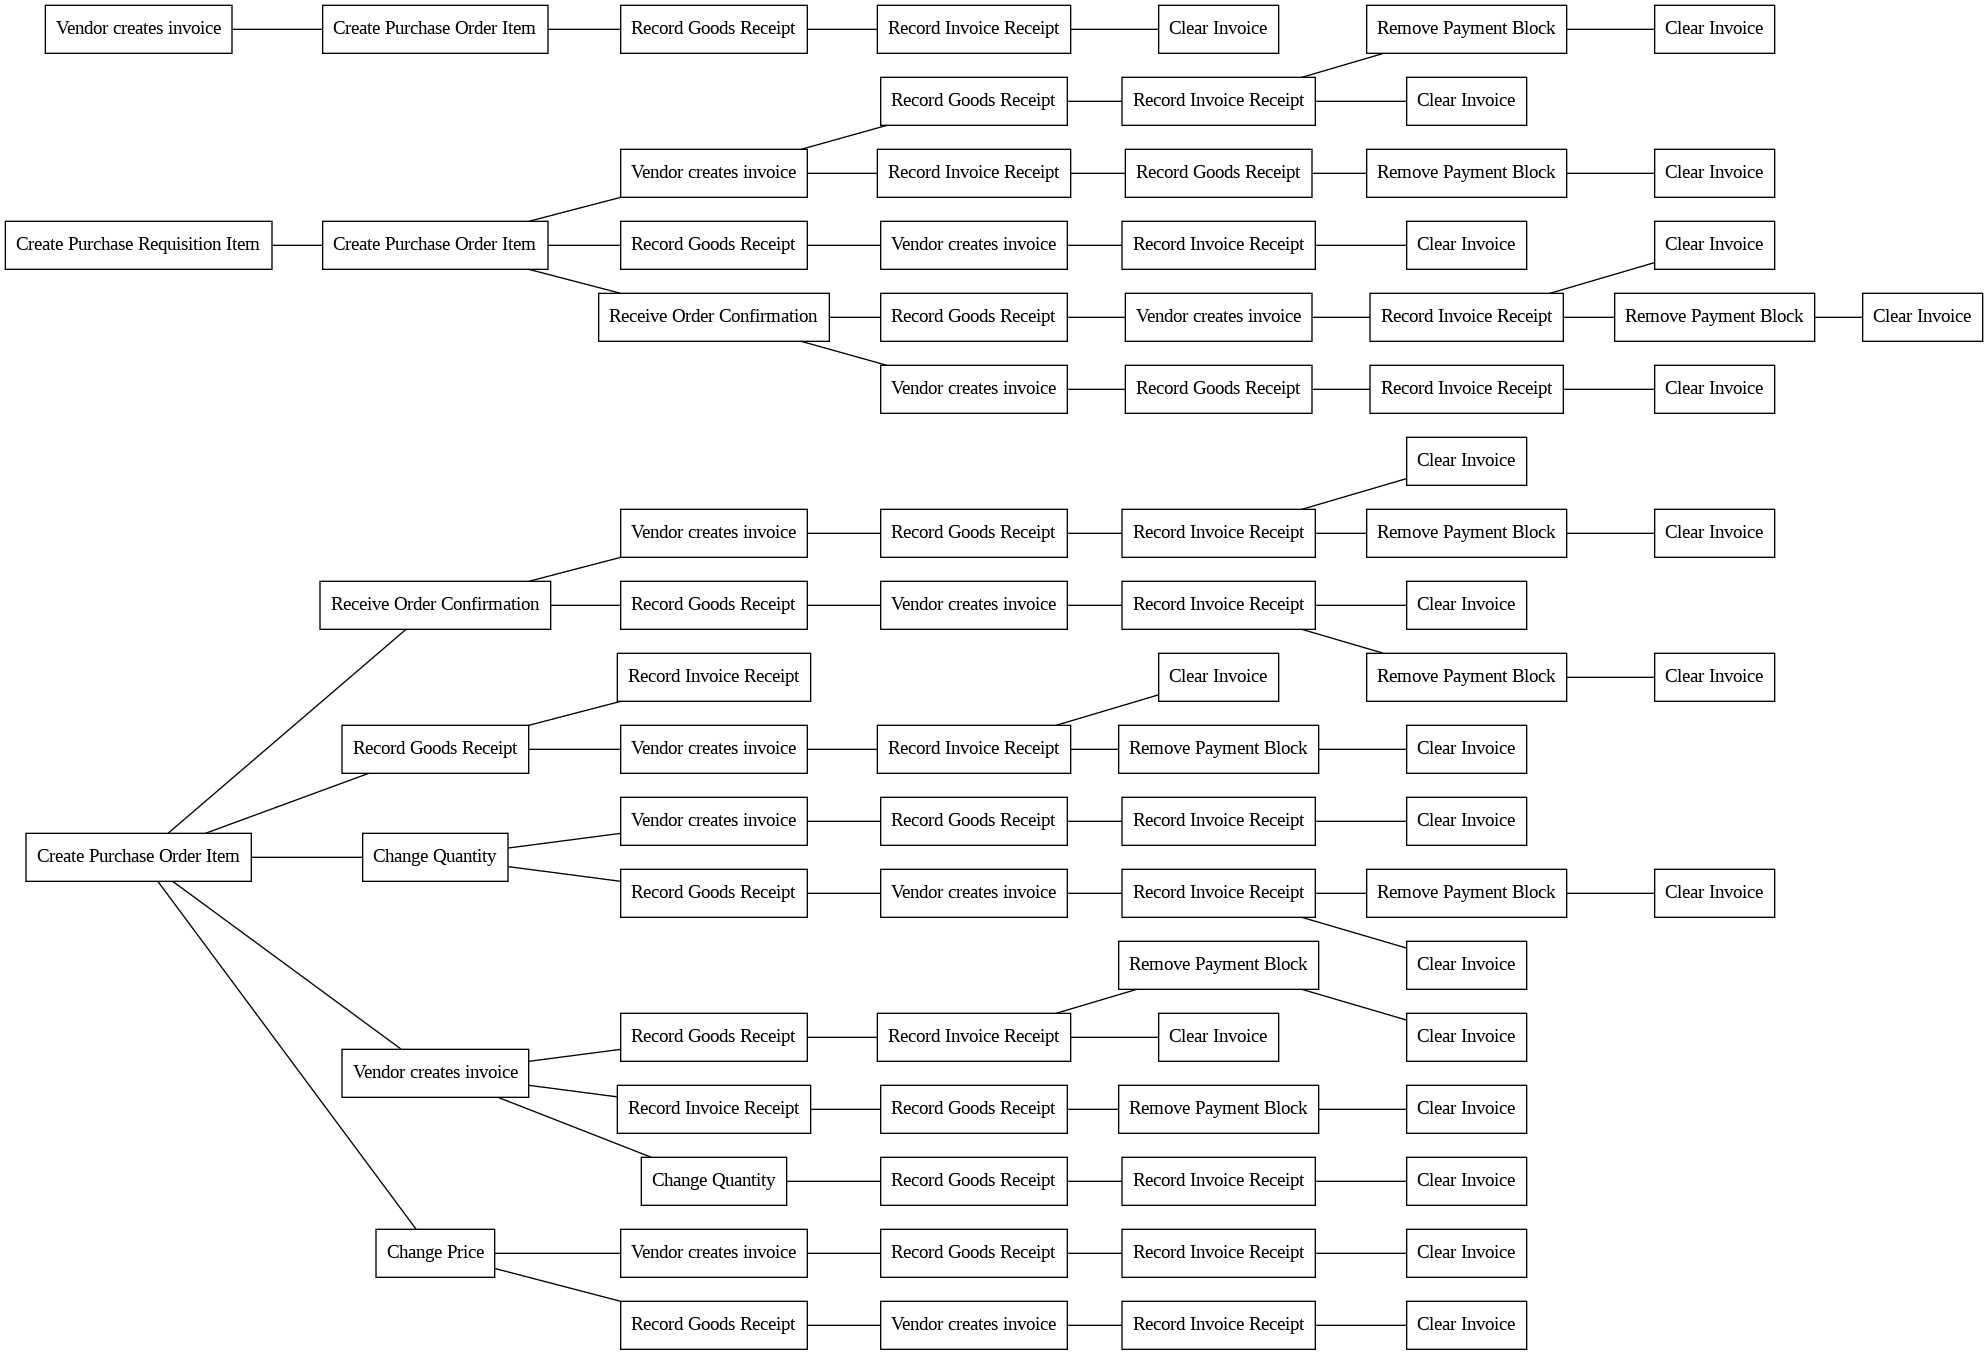

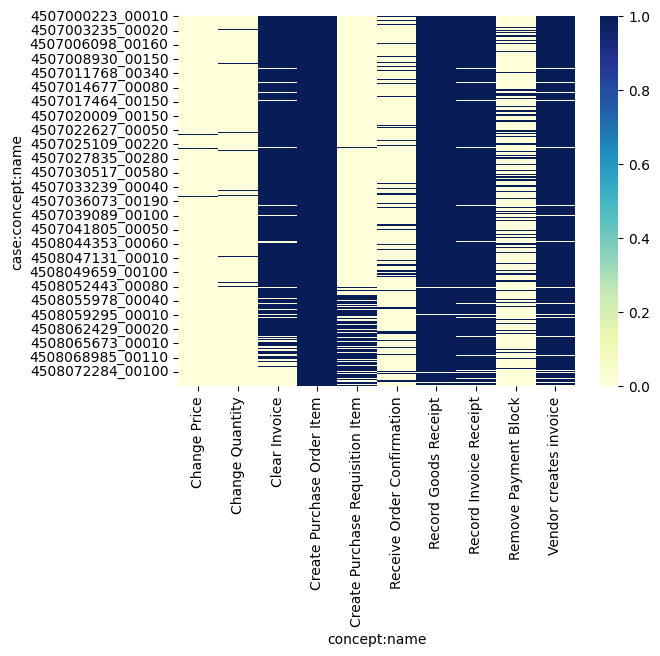

In [22]:
#13
#Process dicovery for 3-way match, invoice before GR

# Commented out IPython magic to ensure Python compatibility.

# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = newData2.pivot_table(index='case:concept:name', aggfunc={'time:timestamp': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
print(case_starts_ends)

case_starts_ends.columns = ['case:concept:name', 'caseend', 'casestart']

# Merge with the main event log data so that for each row we have the start and end times.
newData2 = newData2.merge(case_starts_ends, on='case:concept:name')


# Calculate the relative time by subtracting the process start time from the event timestamp
newData2['cumulativetime'] = newData2['time:timestamp'] - newData2['casestart']
# Convert relative times to more friendly measures
## seconds
newData2['cumulativetime_s'] = newData2['cumulativetime'].dt.seconds + 86400*newData2['cumulativetime'].dt.days
## days
newData2['cumulativedays'] = newData2['cumulativetime'].dt.days

print(newData2)

## Get an array of patient labels for the y axis - for graph labelling purposes
casenums = [int(e) for e in newData2['case:concept:name'].apply(lambda x: x.strip('case:concept:name'))]
## Plot a scatter plot of patient events over relative time
"""
ax = sns.scatterplot(x=newData3['cumulativetime_s'],
y=newData3['case:concept:name'], hue=newData1['concept:name'])
"""
## Create a table giving the number of cases in which each event is present.
my_events = pd.crosstab(newData2['case:concept:name'], newData2['concept:name'])
## Visualise in a heatmap
sns.heatmap(my_events, cmap="YlGnBu")
# Comply to the naming standard of PM4PY

#newData3.rename(columns={'datetime': 'time:timestamp',
#'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)


## Convert to log format
#log = log_converter.apply(log_csv)

## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(newData2)
# Visualise
gviz = dfg_visualization.apply(dfg, log=newData2, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Alpha_miner algorithm
net, im, fm = pm4py.discover_petri_net_alpha(newData2)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')

# Discover petri net using heuristics miner

net, im, fm = pm4py.discover_petri_net_heuristics(newData2, and_threshold = 0.9)

pm4py.view_petri_net(net, im, fm, format='png')

# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(newData2)

pm4py.view_process_tree(process_tree, format='png')

# Discover petri net using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(newData2)

pm4py.view_petri_net(net, im, fm, format='png')

# Discover petri net using  Integer Linear Programming

net, im, fm = pm4py.discover_petri_net_ilp(newData2)

pm4py.view_petri_net(net, im, fm, format='png')

footprints = pm4py.discover_footprints(newData2)
pm4py.view_footprints(footprints, format='png')

prefix_tree = pm4py.discover_prefix_tree(newData2)
pm4py.view_prefix_tree(prefix_tree, format='png')



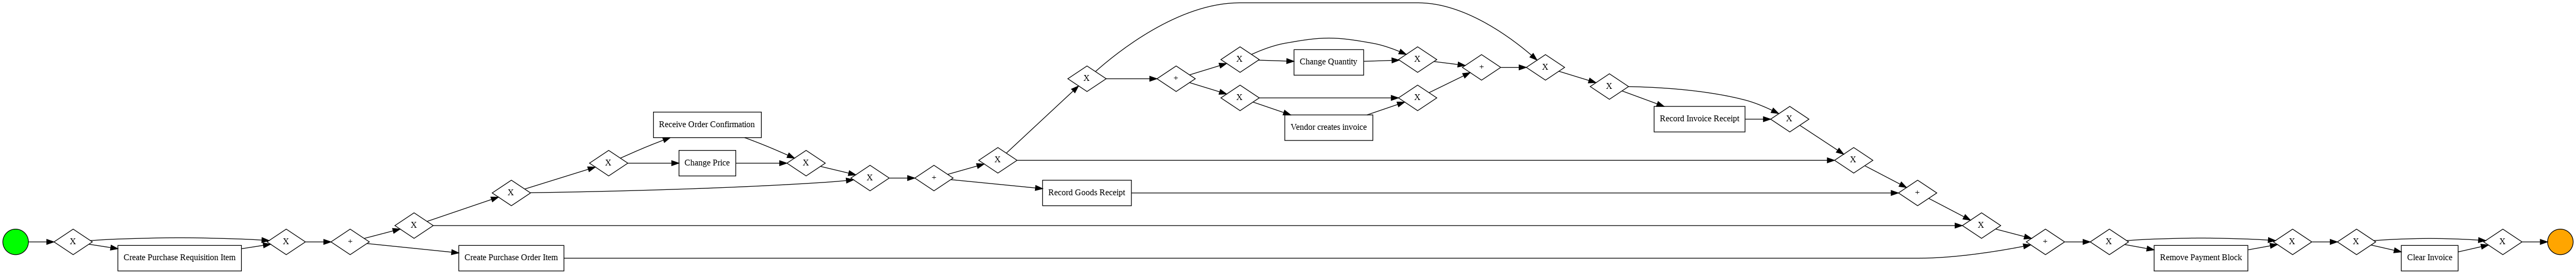

In [23]:
#14
# Discover BPMN net using inductive miner
bpmn_graph = pm4py.discover_bpmn_inductive(newData2)
pm4py.view_bpmn(bpmn_graph)

    case:concept:name            time:timestamp                          
                                            max                       min
0    4507075965_00030 2018-01-04 11:36:00+00:00 2018-01-04 11:25:00+00:00
1    4507075965_00040 2018-01-04 11:36:00+00:00 2018-01-04 11:25:00+00:00
2    4507075965_00070 2018-01-04 11:36:00+00:00 2018-01-04 11:25:00+00:00
3    4507075965_00080 2018-01-04 11:36:00+00:00 2018-01-04 11:25:00+00:00
4    4507075965_00100 2018-01-04 11:36:00+00:00 2018-01-04 11:25:00+00:00
..                ...                       ...                       ...
531  4508076348_00070 2019-01-17 14:00:00+00:00 2019-01-17 13:32:00+00:00
532  4508076348_00080 2019-01-17 14:00:00+00:00 2019-01-17 13:32:00+00:00
533  4508076348_00090 2019-01-17 14:00:00+00:00 2019-01-17 13:32:00+00:00
534  4508076348_00100 2019-01-17 14:00:00+00:00 2019-01-17 13:32:00+00:00
535  4508076348_00110 2019-01-17 14:00:00+00:00 2019-01-17 13:32:00+00:00

[536 rows x 3 columns]
          User

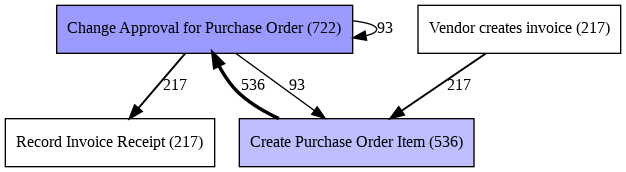

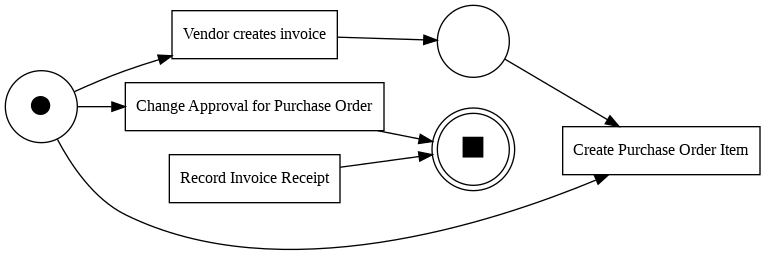

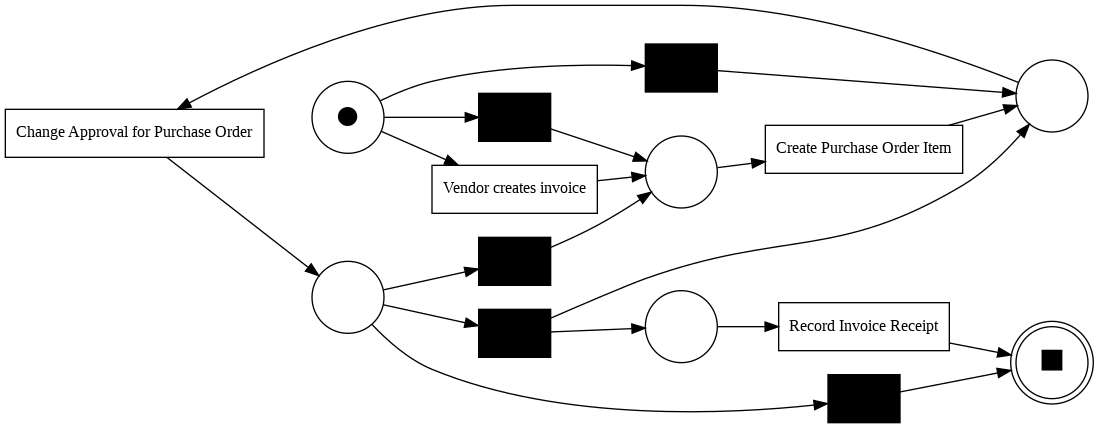

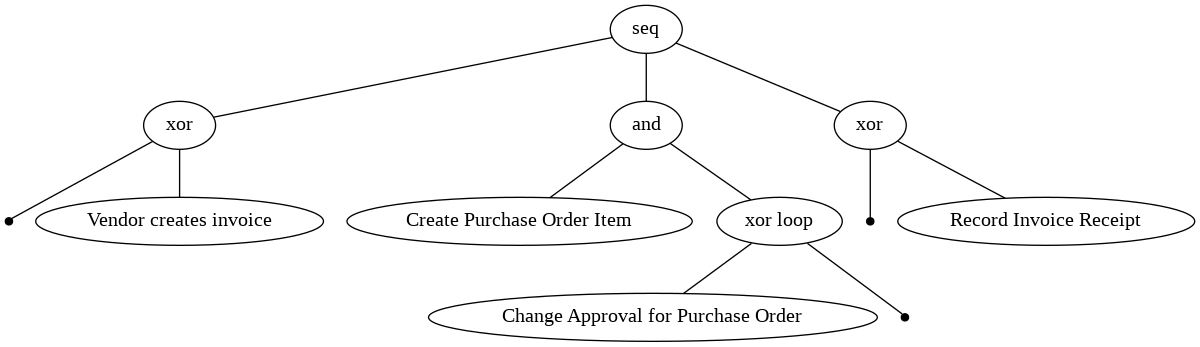

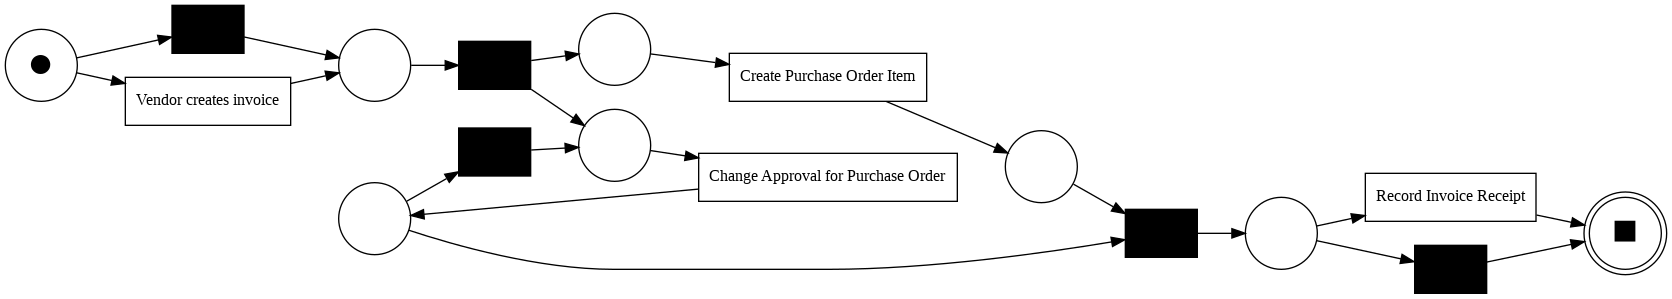

discovering Petri net using ILP miner, completed causal relations ::   0%|          | 0/7 [00:00<?, ?it/s]

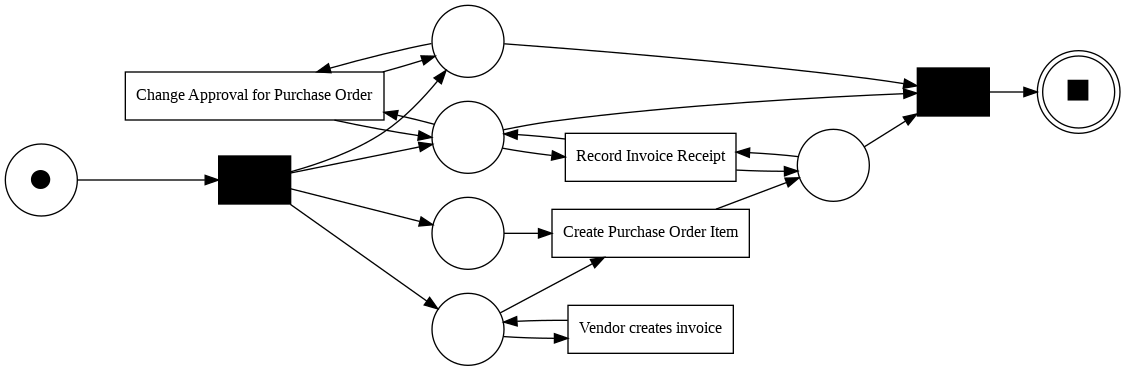

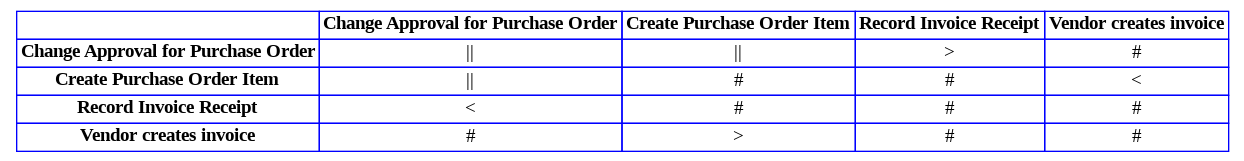

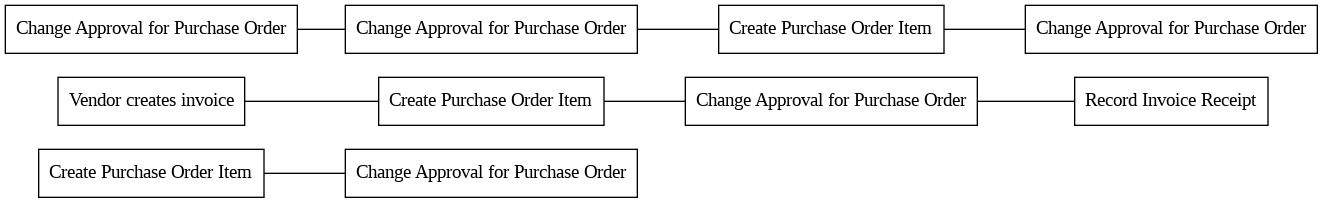

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

trace_is_fit  trace_fitness  \
0              True            1.0   
1              True            1.0   
2              True            1.0   
3              True            1.0   
4              True            1.0   
...             ...            ...   
11643          True            1.0   
11644          True            1.0   
11645          True            1.0   
11646          True            1.0   
11647          True            1.0   

                                   activated_transitions reached_marking  \
0      [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
1      [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
2      [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
3      [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
4      [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
...                                                  ...             ...   
11643  [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
11644  [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
11645  [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
11646  [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   
11647  [(▶, None), (Create Purchase Order Item, 'Crea...       {sink: 1}   

      enabled_transitions_in_marking transitions_with_problems  \
0                                 {}                        []   
1                                 {}                        []   
2                                 {}                        []   
3                                 {}                        []   
4                                 {}                        []   
...                              ...                       ...   
11643                             {}                        []   
11644                             {}                        []   
11645                             {}                        []   
11646                             {}                        []   
11647                             {}                        []   

       missing_tokens  consumed_tokens  remaining_tokens  produced_tokens  
0                   0                7                 0                7  
1                   0                7                 0                7  
2                   0                7                 0                7  
3                   0                7                 0                7  
4                   0                7                 0                7  
...               ...              ...               ...              ...  
11643               0                7                 0                7  
11644               0                7                 0                7  
11645               0                7                 0                7  
11646               0                7                 0                7  
11647               0                7                 0                7  

[11648 rows x 10 columns]

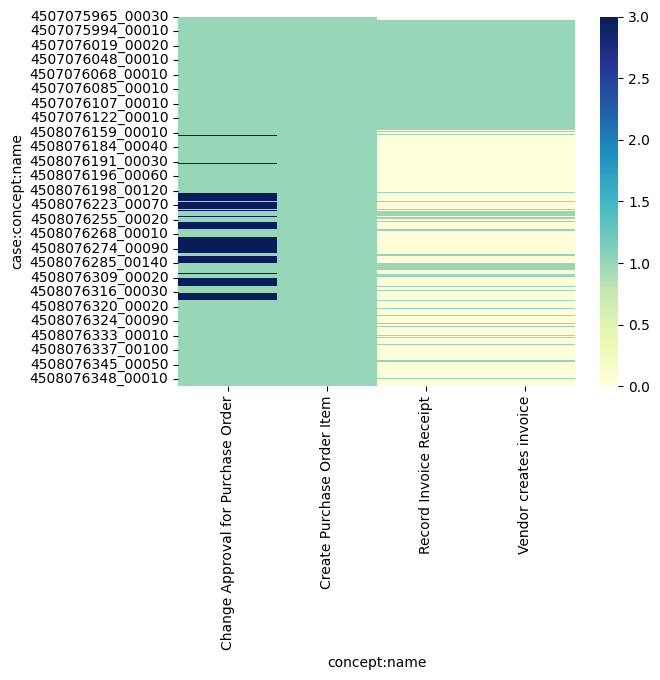

In [24]:
#15
#2-way matching

# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = newData3.pivot_table(index='case:concept:name', aggfunc={'time:timestamp': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
print(case_starts_ends)

case_starts_ends.columns = ['case:concept:name', 'caseend', 'casestart']

# Merge with the main event log data so that for each row we have the start and end times.
newData3 = newData3.merge(case_starts_ends, on='case:concept:name')

# Calculate the relative time by subtracting the process start time from the event timestamp
newData3['cumulativetime'] = newData3['time:timestamp'] - newData3['casestart']
# Convert relative times to more friendly measures
## seconds

newData3['cumulativetime_s'] = newData3['cumulativetime'].dt.seconds + 86400*newData3['cumulativetime'].dt.days
## days
newData3['cumulativedays'] = newData3['cumulativetime'].dt.days

print(newData3)

## Get an array of patient labels for the y axis - for graph labelling purposes
casenums = [int(e) for e in newData3['case:concept:name'].apply(lambda x: x.strip('case:concept:name'))]
## Plot a scatter plot of patient events over relative time
"""
ax = sns.scatterplot(x=newData1['cumulativetime_s'],
y=newData1['case:concept:name'], hue=newData1['concept:name'])
"""

## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(newData3['case:concept:name'], newData3['concept:name'])
## Visualise in a heatmap
sns.heatmap(patient_events, cmap="YlGnBu")
# Comply to the naming standard of PM4PY

#newData1.rename(columns={'datetime': 'time:timestamp',
#'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)


## Convert to log format
#log = log_converter.apply(log_csv)

## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(newData3)
# Visualise
gviz = dfg_visualization.apply(dfg, log=newData3, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Alpha_miner algorithm
net, im, fm = pm4py.discover_petri_net_alpha(newData3)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')

# Discover a Petri Net using Heuristic Miner
net, im, fm = pm4py.discover_petri_net_heuristics(newData3, dependency_threshold=0.9, and_threshold=0.5, loop_two_threshold=0.5)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')


# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(newData3)

pm4py.view_process_tree(process_tree, format='png')

# Discover petri net using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(newData3)

pm4py.view_petri_net(net, im, fm, format='png')

# Discover process tree using ILP Miner
net, im, fm = pm4py.discover_petri_net_ilp(newData3, alpha=0.9)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')


footprints = pm4py.discover_footprints(newData3)
pm4py.view_footprints(footprints, format='png')

prefix_tree = pm4py.discover_prefix_tree(newData3)
pm4py.view_prefix_tree(prefix_tree, format='png')

tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(newData4, net, im, fm)
diagnostics_df = pd.DataFrame.from_dict(tbr_diagnostics)

diagnostics_df

      case:concept:name            time:timestamp                          
                                              max                       min
0      4507000265_00010 2018-01-18 10:02:00+00:00 2018-01-02 08:51:00+00:00
1      4507000265_00020 2018-01-18 10:02:00+00:00 2018-01-02 08:51:00+00:00
2      4507000283_00010 2018-03-12 17:33:00+00:00 2018-01-02 10:08:00+00:00
3      4507000284_00010 2018-03-13 14:26:00+00:00 2018-01-02 10:10:00+00:00
4      4507000290_00010 2018-01-19 06:40:00+00:00 2018-01-02 10:19:00+00:00
...                 ...                       ...                       ...
11643  4508075857_00020 2019-01-02 09:03:00+00:00 2018-12-21 14:01:00+00:00
11644  4508075857_00030 2019-01-02 09:03:00+00:00 2018-12-21 14:01:00+00:00
11645  4508075857_00040 2019-01-02 09:03:00+00:00 2018-12-21 14:01:00+00:00
11646  4508075857_00050 2019-01-02 09:03:00+00:00 2018-12-21 14:01:00+00:00
11647  4508075857_00060 2019-01-02 09:03:00+00:00 2018-12-21 14:01:00+00:00

[11648 rows

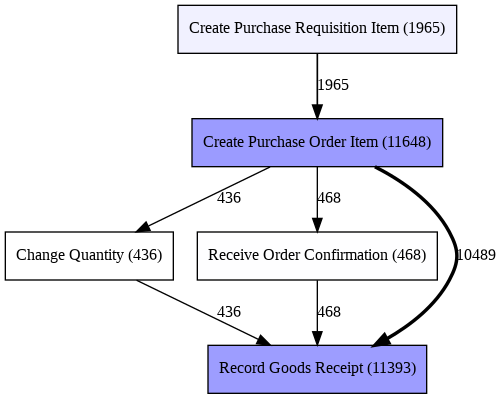

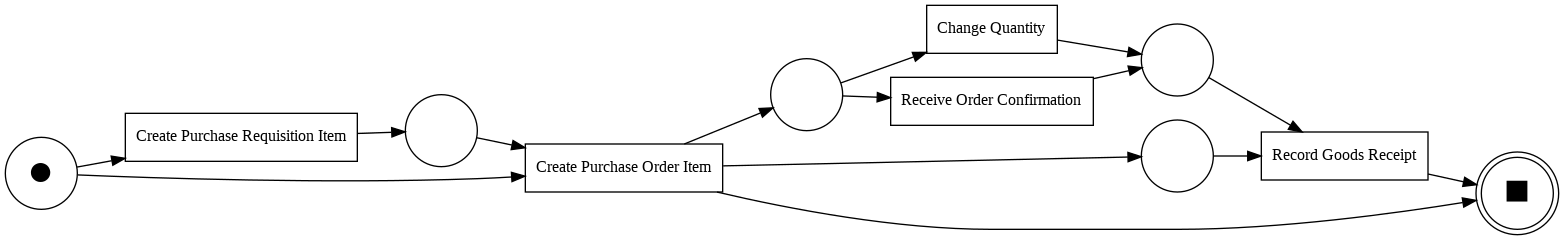

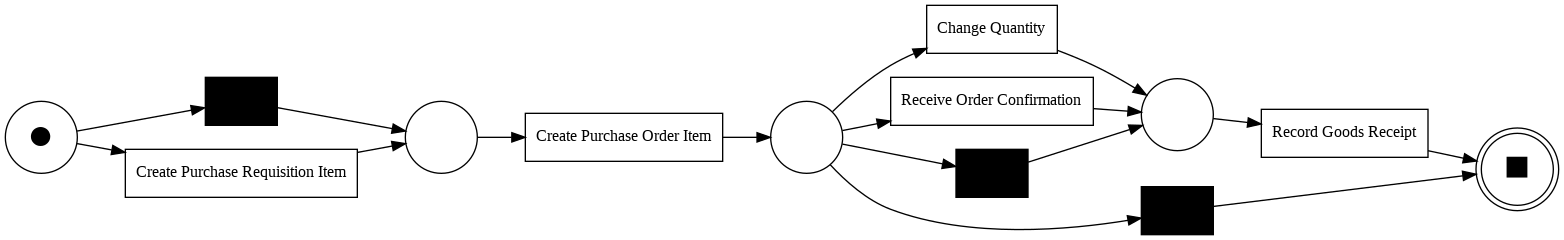

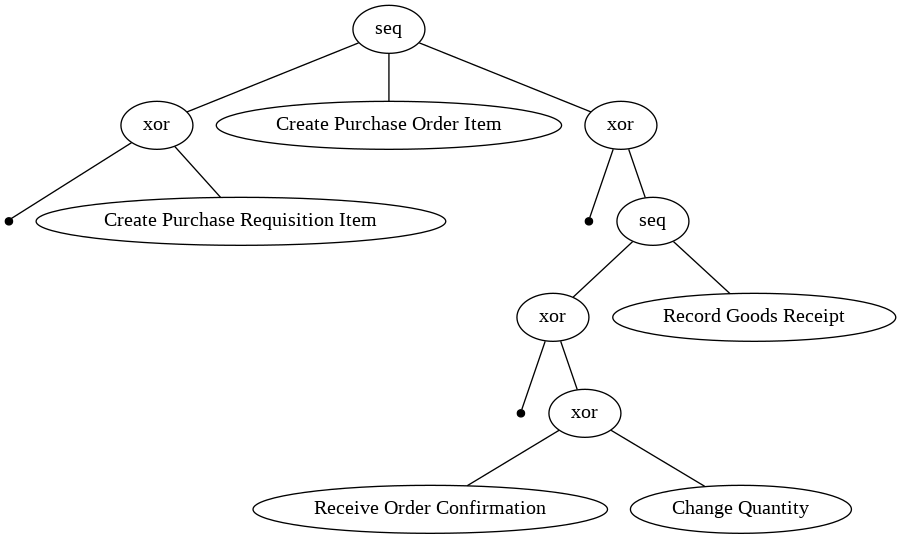

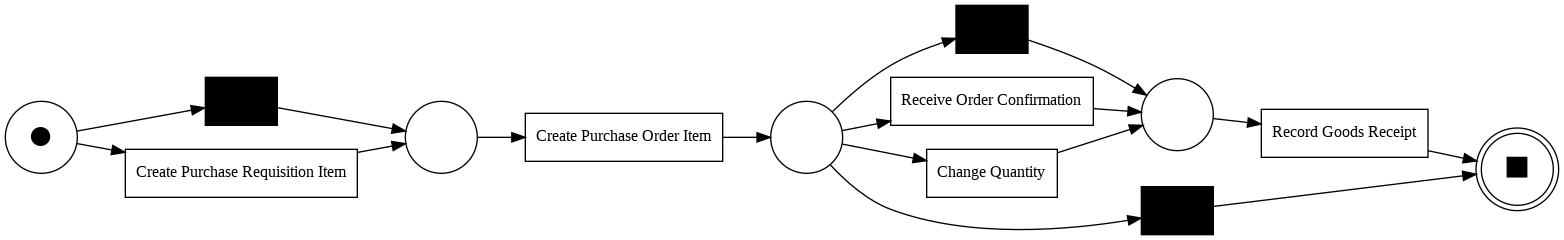

discovering Petri net using ILP miner, completed causal relations ::   0%|          | 0/10 [00:00<?, ?it/s]

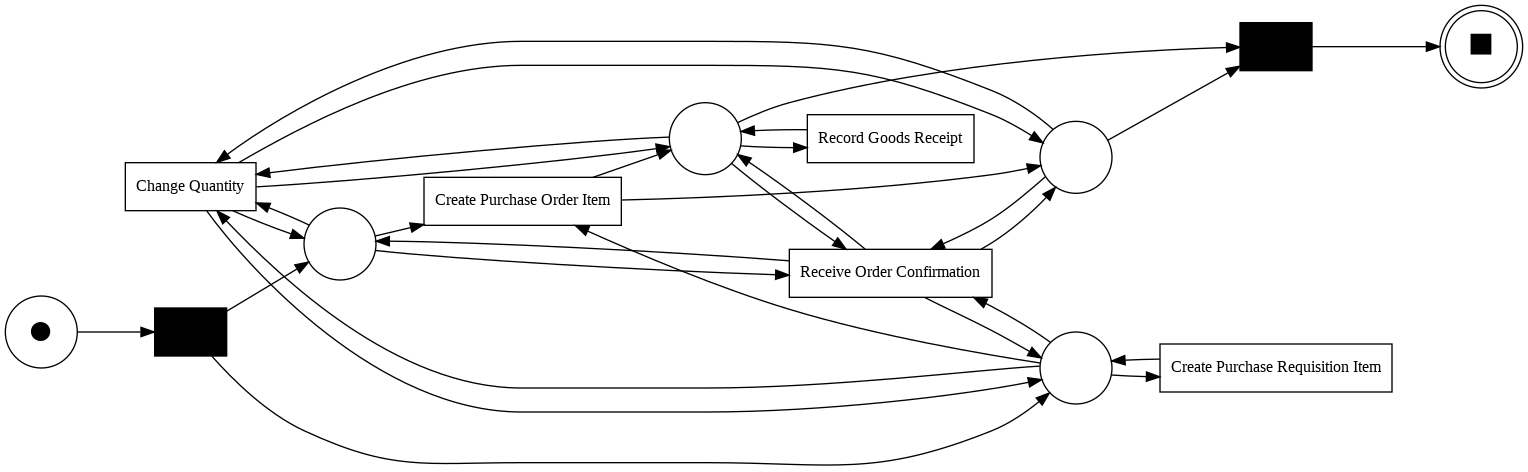

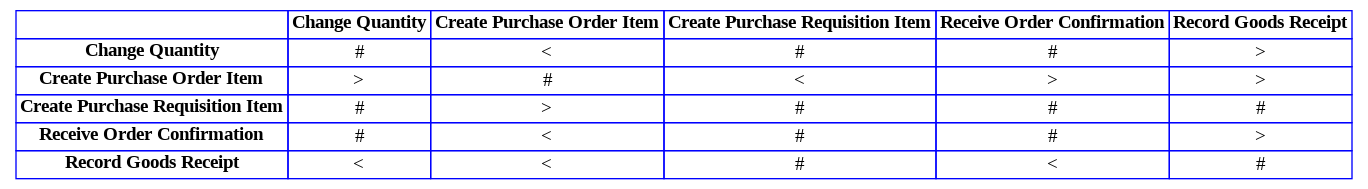

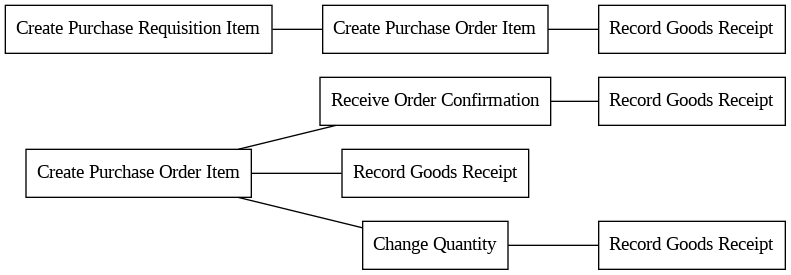

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

trace_is_fit  trace_fitness  \
0              True       1.000000   
1              True       1.000000   
2              True       1.000000   
3              True       1.000000   
4             False       0.818182   
...             ...            ...   
11643          True       1.000000   
11644          True       1.000000   
11645          True       1.000000   
11646          True       1.000000   
11647          True       1.000000   

                                   activated_transitions  \
0      [(▶, None), (Create Purchase Order Item, 'Crea...   
1      [(▶, None), (Create Purchase Order Item, 'Crea...   
2      [(▶, None), (Create Purchase Order Item, 'Crea...   
3      [(▶, None), (Create Purchase Order Item, 'Crea...   
4      [(▶, None), (Create Purchase Order Item, 'Crea...   
...                                                  ...   
11643  [(▶, None), (Create Purchase Order Item, 'Crea...   
11644  [(▶, None), (Create Purchase Order Item, 'Crea...   
11645  [(▶, None), (Create Purchase Order Item, 'Crea...   
11646  [(▶, None), (Create Purchase Order Item, 'Crea...   
11647  [(▶, None), (Create Purchase Order Item, 'Crea...   

             reached_marking  \
0                  {sink: 1}   
1                  {sink: 1}   
2                  {sink: 1}   
3                  {sink: 1}   
4      {2: 1, 5: 1, sink: 1}   
...                      ...   
11643              {sink: 1}   
11644              {sink: 1}   
11645              {sink: 1}   
11646              {sink: 1}   
11647              {sink: 1}   

                          enabled_transitions_in_marking  \
0                                                     {}   
1                                                     {}   
2                                                     {}   
3                                                     {}   
4      {(Create Purchase Order Item, 'Create Purchase...   
...                                                  ...   
11643                                                 {}   
11644                                                 {}   
11645                                                 {}   
11646                                                 {}   
11647                                                 {}   

                    transitions_with_problems  missing_tokens  \
0                                          []               0   
1                                          []               0   
2                                          []               0   
3                                          []               0   
4      [(Change Quantity, 'Change Quantity')]               2   
...                                       ...             ...   
11643                                      []               0   
11644                                      []               0   
11645                                      []               0   
11646                                      []               0   
11647                                      []               0   

       consumed_tokens  remaining_tokens  produced_tokens  
0                    7                 0                7  
1                    7                 0                7  
2                    7                 0                7  
3                    7                 0                7  
4                   11                 2               11  
...                ...               ...              ...  
11643                7                 0                7  
11644                7                 0                7  
11645                7                 0                7  
11646                7                 0                7  
11647                7                 0                7  

[11648 rows x 10 columns]

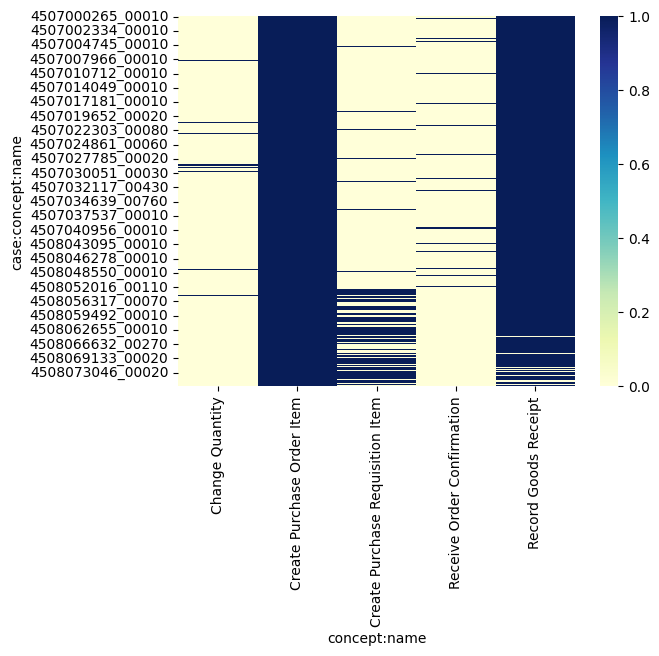

In [36]:
#16
#Consignment

# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = newData4.pivot_table(index='case:concept:name', aggfunc={'time:timestamp': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
print(case_starts_ends)

case_starts_ends.columns = ['case:concept:name', 'caseend', 'casestart']

# Merge with the main event log data so that for each row we have the start and end times.
newData4 = newData4.merge(case_starts_ends, on='case:concept:name')

# Calculate the relative time by subtracting the process start time from the event timestamp
newData4['cumulativetime'] = newData4['time:timestamp'] - newData4['casestart']
# Convert relative times to more friendly measures
## seconds

newData4['cumulativetime_s'] = newData4['cumulativetime'].dt.seconds + 86400*newData4['cumulativetime'].dt.days
## days
newData4['cumulativedays'] = newData4['cumulativetime'].dt.days

print(newData4)

## Get an array of patient labels for the y axis - for graph labelling purposes
casenums = [int(e) for e in newData4['case:concept:name'].apply(lambda x: x.strip('case:concept:name'))]
## Plot a scatter plot of patient events over relative time
"""
ax = sns.scatterplot(x=newData1['cumulativetime_s'],
y=newData1['case:concept:name'], hue=newData1['concept:name'])
"""

## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(newData4['case:concept:name'], newData4['concept:name'])
## Visualise in a heatmap
sns.heatmap(patient_events, cmap="YlGnBu")
# Comply to the naming standard of PM4PY

#newData1.rename(columns={'datetime': 'time:timestamp',
#'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)


## Convert to log format
#log = log_converter.apply(log_csv)

## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(newData4)
# Visualise
gviz = dfg_visualization.apply(dfg, log=newData4, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Alpha_miner algorithm
net, im, fm = pm4py.discover_petri_net_alpha(newData4)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')

# Discover a Petri Net using Heuristic Miner
net, im, fm = pm4py.discover_petri_net_heuristics(newData4, dependency_threshold=0.9, and_threshold=0.5, loop_two_threshold=0.5)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')


# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(newData4)

pm4py.view_process_tree(process_tree, format='png')

# Discover petri net using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(newData4)

pm4py.view_petri_net(net, im, fm, format='png')

# Discover process tree using ILP Miner
net, im, fm = pm4py.discover_petri_net_ilp(newData4, alpha=0.9)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')

footprints = pm4py.discover_footprints(newData4)
pm4py.view_footprints(footprints, format='png')

prefix_tree = pm4py.discover_prefix_tree(newData4)
pm4py.view_prefix_tree(prefix_tree, format='png')

tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(newData4, net, im, fm)
diagnostics_df = pd.DataFrame.from_dict(tbr_diagnostics)

diagnostics_df

In [40]:
#17
#Conformance checking for 3 way matching, invoice after GR, Observing whether eur values are equal or not

my_value=0
my_value2=0
my_value3=0
my_check=False
compliant=0
noncompliant=0

for index, row in use_later_data1.iterrows():
    # Retrieve necessary values for comparison
    if row['concept:name'] == 'Create Purchase Order Item':
      if my_check == True:
        if my_value == my_value2 and my_value == my_value3 and my_value2 == my_value3:
          compliant +=1
        else:
          noncompliant +=1
      my_value = row['Cumulative net worth (EUR)']
      my_check = True
    else:
      if row['concept:name'] == 'Record Goods Receipt':
        my_value2 = row['Cumulative net worth (EUR)']
      if row['concept:name'] == 'Record Invoice Receipt':
        my_value3 = row['Cumulative net worth (EUR)']
if my_value == my_value2 and my_value == my_value3 and my_value2 == my_value3:
  compliant +=1
else:
  noncompliant +=1

print('Number of compliant cases:')
print(compliant)
print('Number of noncompliant cases:')
print(noncompliant)
percentage = (noncompliant*100)/(compliant + noncompliant)
print('As a result, '+ str(percentage) + ' percent of the cases is not compliant with the rules of the company')

Number of compliant cases:
6422
Number of noncompliant cases:
655
As a result, 9.255334181150205 percent of the cases is not compliant with the rules of the company


In [42]:
#18
#Conformance checking for 3 way matching invoive before GR, Observing whether eur values are equal or not

my_value=0
my_value2=0
my_value3=0
my_check=False
compliant=0
noncompliant=0

for index, row in use_later_data2.iterrows():
    # Retrieve necessary values for comparison
    if row['concept:name'] == 'Create Purchase Order Item':
      if my_check == True:
        if my_value == my_value2 and my_value == my_value3 and my_value2 == my_value3:
          compliant +=1
        else:
          noncompliant +=1
      my_value = row['Cumulative net worth (EUR)']
      my_check = True
    else:
      if row['concept:name'] == 'Record Goods Receipt':
        my_value2 = row['Cumulative net worth (EUR)']
      if row['concept:name'] == 'Record Invoice Receipt':
        my_value3 = row['Cumulative net worth (EUR)']
if my_value == my_value2 and my_value == my_value3 and my_value2 == my_value3:
  compliant +=1
else:
  noncompliant +=1

print('Number of compliant cases:')
print(compliant)
print('Number of noncompliant cases:')
print(noncompliant)
percentage = (noncompliant*100)/(compliant + noncompliant)
print('As a result, '+ str(percentage) + ' percent of the cases is not compliant with the rules of the company')

Number of compliant cases:
164356
Number of noncompliant cases:
6404
As a result, 3.750292808620286 percent of the cases is not compliant with the rules of the company


In [43]:
#19
#Conformance checking for 2 way matching, Observing whether eur values are equal or not

my_value=0
my_value2=0
my_value3=0
my_check=False
compliant=0
noncompliant=0

for index, row in use_later_data3.iterrows():
    # Retrieve necessary values for comparison
    if row['concept:name'] == 'Create Purchase Order Item':
      if my_check == True:
        if my_value == my_value3:
          compliant +=1
        else:
          noncompliant +=1
      my_value = row['Cumulative net worth (EUR)']
      my_check = True
    else:
      if row['concept:name'] == 'Record Invoice Receipt':
        my_value3 = row['Cumulative net worth (EUR)']
if my_value == my_value3:
  compliant +=1
else:
  noncompliant +=1

print('Number of compliant cases:')
print(compliant)
print('Number of noncompliant cases:')
print(noncompliant)
percentage = (noncompliant*100)/(compliant + noncompliant)
print('As a result, '+ str(percentage) + ' percent of the cases is not compliant with the rules of the company')

Number of compliant cases:
301
Number of noncompliant cases:
235
As a result, 43.843283582089555 percent of the cases is not compliant with the rules of the company


In [44]:
#20
#Comparative process mining
import numpy as np
from scipy.stats import chi2

observed = np.array([[6269, 642], [159257, 5909], [301, 142]])
expected = np.array([[6911, 0], [165166, 0], [443, 0]])
# Add a small constant value to expected frequencies
expected += 1 #to be sure there is no zero frequency that may lead to error in the calculations.

# Calculate the chi-square statistic
chi2_statistic = np.sum((observed - expected)**2 / expected)

# Calculate the critical value
degrees_of_freedom = (observed.shape[0] - 1) * (observed.shape[1] - 1)
critical_value = chi2.ppf(0.95, degrees_of_freedom)

# Print the chi-square statistic and critical value
print("Chi-square Statistic:", chi2_statistic)
print("Critical Value:", critical_value)

# Compare the test statistic with the critical value and interpret the results
if chi2_statistic > critical_value:
    print("The observed frequencies significantly differ from the expected frequencies, indicating a significant difference.")
else:
    print("The observed frequencies do not significantly differ from the expected frequencies, indicating no significant difference.")

Chi-square Statistic: 35335543.34384304
Critical Value: 5.991464547107979
The observed frequencies significantly differ from the expected frequencies, indicating a significant difference.
